## Appendix: Investigating Slice Layer Bug

Must have preprocessing component ran and the DataFrame saved to disk, of the main notebook.

In [4]:
# Importing Libraries and Configuring virtual GPU

import os
import json
import pickle
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from fractions import Fraction
from functools import reduce
from tensorflow import keras
from tensorflow.keras import layers

gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))

if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Random Seed
seed = 15
tf.random.set_seed(seed)

with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [5]:
def to_time_series(df, columns, n_trail=1, n_lead=1):
    '''
    :param df: DataFrame, dataframe object where the columns are the features and labels and the rows are days
    :param columns: list of strings, names of the features and labels (columns of df) to be used in the time series
    :param n_trail: int, number of days behind day 0 that will be used to predict days after day 0
    :param n_lead: int, number of days ahead of day 0 that will be predicted
    
    ---> DataFrame, dataframe object structured like a time series where each row represents an element in the time
                    series, and each column is a feature or label a certain amount of days in the future or past.
    '''
    df = df[columns]
    dfs = []
    col_names = []
    
    # Create trailing columns
    for i in range(n_trail, 0, -1):
        dfs.append(df.shift(-i))
        col_names += [(col_name + '(t-{})'.format(i)) for col_name in columns]
        
    # Create leading columns
    for i in range(0, n_lead+1):
        dfs.append(df.shift(i))
        col_names += [(col_name + '(t+{})'.format(i)) for col_name in columns]
        
    agg = pd.concat(dfs, axis=1)
    agg.columns = col_names
    
    agg.dropna(inplace=True)
    
    return agg

# Testing Function
test_df = pd.DataFrame([(1, 'a'), (2, 'b'), (3, 'c'),
                        (4, 'd'), (5, 'e'), (6, 'f'),
                        (7, 'g'), (8, 'h'), (9, 'i'),
                        (10, 'j'), (11, 'k'), (12, 'l'),
                        (13, 'm'), (14, 'n'), (15, 'o'),
                        (16, 'p'), (17, 'q'), (18, 'r'),
                        (19, 's'), (20, 't'), (21, 'u'),
                        (22, 'v'), (23, 'w'), (24, 'x'),
                        (25, 'y'), (26, 'z')], columns=['numbers', 'letters'])
test_df = test_df.reindex(index=test_df.index[::-1])
print('Test DataFrame:')
print(test_df)
df = to_time_series(test_df, columns=test_df.columns, n_trail=5)
print()
print('Time Series DataFrame with a window size of n_trail+1')
print(df)

Test DataFrame:
    numbers letters
25       26       z
24       25       y
23       24       x
22       23       w
21       22       v
20       21       u
19       20       t
18       19       s
17       18       r
16       17       q
15       16       p
14       15       o
13       14       n
12       13       m
11       12       l
10       11       k
9        10       j
8         9       i
7         8       h
6         7       g
5         6       f
4         5       e
3         4       d
2         3       c
1         2       b
0         1       a

Time Series DataFrame with a window size of n_trail+1
    numbers(t-5) letters(t-5)  numbers(t-4) letters(t-4)  numbers(t-3)  \
24          20.0            t          21.0            u          22.0   
23          19.0            s          20.0            t          21.0   
22          18.0            r          19.0            s          20.0   
21          17.0            q          18.0            r          19.0   
20          16.0   

### Using only pricing data from one ticker

In [4]:
# Hyperparameters
dataset_size = 1000
batch_size = 1000

preprocessed_df = pd.read_csv(os.path.join(path_to_data, 'preprocessed.csv'), parse_dates=['timestamp'])

features_to_test = ['log_adj_daily_returns']
data_df = preprocessed_df[['timestamp'] + ['_'.join([feature, t]) for t in tickers for feature in features_to_test]]
data_df.head(8)

,timestamp,log_adj_daily_returns_WFC,log_adj_daily_returns_JPM,log_adj_daily_returns_BAC,log_adj_daily_returns_C
0,2019-10-22,0.003166,0.009986,0.005786,0.003475
1,2019-10-21,0.009758,0.024498,0.021836,0.029250
2,2019-10-18,0.007230,0.001743,0.002970,0.002009
3,2019-10-17,0.000403,0.005583,0.002979,0.001438
4,2019-10-16,-0.010431,-0.002337,0.014691,-0.024447
5,2019-10-15,0.016905,0.029696,0.020045,0.013856
6,2019-10-14,0.001219,0.002666,0.007924,0.001995
7,2019-10-11,0.011445,0.016758,0.016039,0.021339


In [20]:
df = to_time_series(data_df, data_df.columns, n_trail=5)
df.head()

,timestamp(t-5),log_adj_daily_returns_WFC(t-5),log_adj_daily_returns_JPM(t-5),log_adj_daily_returns_BAC(t-5),log_adj_daily_returns_C(t-5),timestamp(t-4),log_adj_daily_returns_WFC(t-4),log_adj_daily_returns_JPM(t-4),log_adj_daily_returns_BAC(t-4),log_adj_daily_returns_C(t-4),...,timestamp(t+0),log_adj_daily_returns_WFC(t+0),log_adj_daily_returns_JPM(t+0),log_adj_daily_returns_BAC(t+0),log_adj_daily_returns_C(t+0),timestamp(t+1),log_adj_daily_returns_WFC(t+1),log_adj_daily_returns_JPM(t+1),log_adj_daily_returns_BAC(t+1),log_adj_daily_returns_C(t+1)
1,2019-10-14,0.001219,0.002666,0.007924,0.001995,2019-10-15,0.016905,0.029696,0.020045,0.013856,...,2019-10-21,0.009758,0.024498,0.021836,0.029250,2019-10-22,0.003166,0.009986,0.005786,0.003475
2,2019-10-11,0.011445,0.016758,0.016039,0.021339,2019-10-14,0.001219,0.002666,0.007924,0.001995,...,2019-10-18,0.007230,0.001743,0.002970,0.002009,2019-10-21,0.009758,0.024498,0.021836,0.029250
3,2019-10-10,0.010331,0.013931,0.019880,0.017494,2019-10-11,0.011445,0.016758,0.016039,0.021339,...,2019-10-17,0.000403,0.005583,0.002979,0.001438,2019-10-18,0.007230,0.001743,0.002970,0.002009
4,2019-10-09,0.006877,0.007218,0.009366,0.015393,2019-10-10,0.010331,0.013931,0.019880,0.017494,...,2019-10-16,-0.010431,-0.002337,0.014691,-0.024447,2019-10-17,0.000403,0.005583,0.002979,0.001438
5,2019-10-08,-0.020491,-0.022548,-0.024313,-0.026014,2019-10-09,0.006877,0.007218,0.009366,0.015393,...,2019-10-15,0.016905,0.029696,0.020045,0.013856,2019-10-16,-0.010431,-0.002337,0.014691,-0.024447


In [21]:
column_names_by_ticker = [[name for name in df.columns if 'log_adj_daily_returns_' + t in name] for t in tickers]
print(column_names_by_ticker)
# Using only data from ticker WFC
cols = column_names_by_ticker[0]

[['log_adj_daily_returns_WFC(t-5)', 'log_adj_daily_returns_WFC(t-4)', 'log_adj_daily_returns_WFC(t-3)', 'log_adj_daily_returns_WFC(t-2)', 'log_adj_daily_returns_WFC(t-1)', 'log_adj_daily_returns_WFC(t+0)', 'log_adj_daily_returns_WFC(t+1)'], ['log_adj_daily_returns_JPM(t-5)', 'log_adj_daily_returns_JPM(t-4)', 'log_adj_daily_returns_JPM(t-3)', 'log_adj_daily_returns_JPM(t-2)', 'log_adj_daily_returns_JPM(t-1)', 'log_adj_daily_returns_JPM(t+0)', 'log_adj_daily_returns_JPM(t+1)'], ['log_adj_daily_returns_BAC(t-5)', 'log_adj_daily_returns_BAC(t-4)', 'log_adj_daily_returns_BAC(t-3)', 'log_adj_daily_returns_BAC(t-2)', 'log_adj_daily_returns_BAC(t-1)', 'log_adj_daily_returns_BAC(t+0)', 'log_adj_daily_returns_BAC(t+1)'], ['log_adj_daily_returns_C(t-5)', 'log_adj_daily_returns_C(t-4)', 'log_adj_daily_returns_C(t-3)', 'log_adj_daily_returns_C(t-2)', 'log_adj_daily_returns_C(t-1)', 'log_adj_daily_returns_C(t+0)', 'log_adj_daily_returns_C(t+1)']]


In [22]:
# Checking if columns are still in the right order
df[cols].head()

,log_adj_daily_returns_WFC(t-5),log_adj_daily_returns_WFC(t-4),log_adj_daily_returns_WFC(t-3),log_adj_daily_returns_WFC(t-2),log_adj_daily_returns_WFC(t-1),log_adj_daily_returns_WFC(t+0),log_adj_daily_returns_WFC(t+1)
1,0.001219,0.016905,-0.010431,0.000403,0.007230,0.009758,0.003166
2,0.011445,0.001219,0.016905,-0.010431,0.000403,0.007230,0.009758
3,0.010331,0.011445,0.001219,0.016905,-0.010431,0.000403,0.007230
4,0.006877,0.010331,0.011445,0.001219,0.016905,-0.010431,0.000403
5,-0.020491,0.006877,0.010331,0.011445,0.001219,0.016905,-0.010431


In [23]:
dataset = df[cols].values
print('Length of Dataset: {}'.format(len(dataset)))

Length of Dataset: 5024


In [24]:
print(dataset[0])

[ 0.00121852  0.01690521 -0.01043139  0.00040323  0.0072304   0.00975812
  0.00316581]


In [25]:
# Shuffling and Sampling Dataset
shuffled_indices = np.random.choice(len(dataset), size=dataset_size, replace=False)
assert (len(shuffled_indices) == dataset_size) and (shuffled_indices.dtype == np.int64)
shuffled_dataset = dataset[shuffled_indices]
print('Shuffled Dataset size: {}'.format(len(shuffled_dataset)))

Shuffled Dataset size: 1000


In [26]:
# Spliting Dataset into Features and Labels
X, y = shuffled_dataset[:, :-1], shuffled_dataset[:, -1]

#### Regression Modeling

In [27]:
# Creating a Model and attempting to overfit it
## Defining Model
tf.keras.backend.clear_session()
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
num_features = tf.expand_dims(input_log_returns, -1)
ts_layer_1 = layers.LSTM(500, return_sequences=True)(num_features)
ts_layer_2 = layers.LSTM(500, return_sequences=True)(ts_layer_1)
ts_layer_3 = layers.LSTM(300, return_sequences=True)(ts_layer_2)
ts_layer_4 = layers.LSTM(160, return_sequences=True)(ts_layer_3)
ts_layer_5 = layers.LSTM(50, return_sequences=False)(ts_layer_4)
output = layers.Dense(1)(ts_layer_5)
model = keras.Model(input_log_returns, output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=None)
print(model.summary())

history = model.fit(x=X, y=y, batch_size=batch_size, epochs=900, validation_data=(X, y))

Model: "test_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
log_adj_daily_returns (Input [(None, 6)]               0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 6, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 500)            1004000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 500)            2002000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 300)            961200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 6, 160)            295040    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                4

Epoch 60/900
1000/1000 [==============================] - 0s 92us/sample - loss: 5.5166e-04 - val_loss: 5.5156e-04
Epoch 61/900
1000/1000 [==============================] - 0s 90us/sample - loss: 5.5156e-04 - val_loss: 5.5146e-04
Epoch 62/900
1000/1000 [==============================] - 0s 97us/sample - loss: 5.5146e-04 - val_loss: 5.5139e-04
Epoch 63/900
1000/1000 [==============================] - 0s 108us/sample - loss: 5.5139e-04 - val_loss: 5.5140e-04
Epoch 64/900
1000/1000 [==============================] - 0s 102us/sample - loss: 5.5140e-04 - val_loss: 5.5145e-04
Epoch 65/900
1000/1000 [==============================] - 0s 100us/sample - loss: 5.5145e-04 - val_loss: 5.5150e-04
Epoch 66/900
1000/1000 [==============================] - 0s 103us/sample - loss: 5.5150e-04 - val_loss: 5.5152e-04
Epoch 67/900
1000/1000 [==============================] - 0s 96us/sample - loss: 5.5152e-04 - val_loss: 5.5150e-04
Epoch 68/900
1000/1000 [==============================] - 0s 93us/sample - l

Epoch 131/900
1000/1000 [==============================] - 0s 93us/sample - loss: 5.5130e-04 - val_loss: 5.5130e-04
Epoch 132/900
1000/1000 [==============================] - 0s 97us/sample - loss: 5.5130e-04 - val_loss: 5.5129e-04
Epoch 133/900
1000/1000 [==============================] - 0s 98us/sample - loss: 5.5129e-04 - val_loss: 5.5129e-04
Epoch 134/900
1000/1000 [==============================] - 0s 97us/sample - loss: 5.5129e-04 - val_loss: 5.5129e-04
Epoch 135/900
1000/1000 [==============================] - 0s 95us/sample - loss: 5.5129e-04 - val_loss: 5.5129e-04
Epoch 136/900
1000/1000 [==============================] - 0s 94us/sample - loss: 5.5129e-04 - val_loss: 5.5129e-04
Epoch 137/900
1000/1000 [==============================] - 0s 101us/sample - loss: 5.5129e-04 - val_loss: 5.5128e-04
Epoch 138/900
1000/1000 [==============================] - 0s 97us/sample - loss: 5.5128e-04 - val_loss: 5.5128e-04
Epoch 139/900
1000/1000 [==============================] - 0s 98us/samp

Epoch 202/900
1000/1000 [==============================] - 0s 96us/sample - loss: 5.5097e-04 - val_loss: 5.5096e-04
Epoch 203/900
1000/1000 [==============================] - 0s 98us/sample - loss: 5.5096e-04 - val_loss: 5.5095e-04
Epoch 204/900
1000/1000 [==============================] - 0s 98us/sample - loss: 5.5095e-04 - val_loss: 5.5094e-04
Epoch 205/900
1000/1000 [==============================] - 0s 99us/sample - loss: 5.5094e-04 - val_loss: 5.5093e-04
Epoch 206/900
1000/1000 [==============================] - 0s 93us/sample - loss: 5.5093e-04 - val_loss: 5.5092e-04
Epoch 207/900
1000/1000 [==============================] - 0s 95us/sample - loss: 5.5092e-04 - val_loss: 5.5091e-04
Epoch 208/900
1000/1000 [==============================] - 0s 100us/sample - loss: 5.5091e-04 - val_loss: 5.5089e-04
Epoch 209/900
1000/1000 [==============================] - 0s 99us/sample - loss: 5.5089e-04 - val_loss: 5.5088e-04
Epoch 210/900
1000/1000 [==============================] - 0s 95us/samp

Epoch 273/900
1000/1000 [==============================] - 0s 96us/sample - loss: 5.4776e-04 - val_loss: 5.4765e-04
Epoch 274/900
1000/1000 [==============================] - 0s 97us/sample - loss: 5.4765e-04 - val_loss: 5.4754e-04
Epoch 275/900
1000/1000 [==============================] - 0s 101us/sample - loss: 5.4754e-04 - val_loss: 5.4743e-04
Epoch 276/900
1000/1000 [==============================] - 0s 100us/sample - loss: 5.4743e-04 - val_loss: 5.4733e-04
Epoch 277/900
1000/1000 [==============================] - 0s 99us/sample - loss: 5.4733e-04 - val_loss: 5.4723e-04
Epoch 278/900
1000/1000 [==============================] - 0s 102us/sample - loss: 5.4723e-04 - val_loss: 5.4714e-04
Epoch 279/900
1000/1000 [==============================] - 0s 97us/sample - loss: 5.4714e-04 - val_loss: 5.4705e-04
Epoch 280/900
1000/1000 [==============================] - 0s 102us/sample - loss: 5.4705e-04 - val_loss: 5.4696e-04
Epoch 281/900
1000/1000 [==============================] - 0s 96us/s

Epoch 344/900
1000/1000 [==============================] - 0s 100us/sample - loss: 5.4606e-04 - val_loss: 5.4598e-04
Epoch 345/900
1000/1000 [==============================] - 0s 101us/sample - loss: 5.4598e-04 - val_loss: 5.4603e-04
Epoch 346/900
1000/1000 [==============================] - 0s 101us/sample - loss: 5.4603e-04 - val_loss: 5.4600e-04
Epoch 347/900
1000/1000 [==============================] - 0s 100us/sample - loss: 5.4600e-04 - val_loss: 5.4599e-04
Epoch 348/900
1000/1000 [==============================] - 0s 100us/sample - loss: 5.4599e-04 - val_loss: 5.4601e-04
Epoch 349/900
1000/1000 [==============================] - 0s 100us/sample - loss: 5.4601e-04 - val_loss: 5.4596e-04
Epoch 350/900
1000/1000 [==============================] - 0s 99us/sample - loss: 5.4596e-04 - val_loss: 5.4599e-04
Epoch 351/900
1000/1000 [==============================] - 0s 97us/sample - loss: 5.4599e-04 - val_loss: 5.4595e-04
Epoch 352/900
1000/1000 [==============================] - 0s 97us

Epoch 415/900
1000/1000 [==============================] - 0s 103us/sample - loss: 5.4448e-04 - val_loss: 5.4445e-04
Epoch 416/900
1000/1000 [==============================] - 0s 108us/sample - loss: 5.4445e-04 - val_loss: 5.4441e-04
Epoch 417/900
1000/1000 [==============================] - 0s 106us/sample - loss: 5.4441e-04 - val_loss: 5.4438e-04
Epoch 418/900
1000/1000 [==============================] - 0s 105us/sample - loss: 5.4438e-04 - val_loss: 5.4434e-04
Epoch 419/900
1000/1000 [==============================] - 0s 105us/sample - loss: 5.4434e-04 - val_loss: 5.4431e-04
Epoch 420/900
1000/1000 [==============================] - 0s 110us/sample - loss: 5.4431e-04 - val_loss: 5.4428e-04
Epoch 421/900
1000/1000 [==============================] - 0s 103us/sample - loss: 5.4428e-04 - val_loss: 5.4424e-04
Epoch 422/900
1000/1000 [==============================] - 0s 107us/sample - loss: 5.4424e-04 - val_loss: 5.4420e-04
Epoch 423/900
1000/1000 [==============================] - 0s 10

1000/1000 [==============================] - 0s 105us/sample - loss: 5.4059e-04 - val_loss: 5.4051e-04
Epoch 486/900
1000/1000 [==============================] - 0s 110us/sample - loss: 5.4051e-04 - val_loss: 5.4043e-04
Epoch 487/900
1000/1000 [==============================] - 0s 103us/sample - loss: 5.4043e-04 - val_loss: 5.4035e-04
Epoch 488/900
1000/1000 [==============================] - 0s 108us/sample - loss: 5.4035e-04 - val_loss: 5.4027e-04
Epoch 489/900
1000/1000 [==============================] - 0s 106us/sample - loss: 5.4027e-04 - val_loss: 5.4019e-04
Epoch 490/900
1000/1000 [==============================] - 0s 105us/sample - loss: 5.4019e-04 - val_loss: 5.4011e-04
Epoch 491/900
1000/1000 [==============================] - 0s 103us/sample - loss: 5.4011e-04 - val_loss: 5.4002e-04
Epoch 492/900
1000/1000 [==============================] - 0s 104us/sample - loss: 5.4002e-04 - val_loss: 5.3994e-04
Epoch 493/900
1000/1000 [==============================] - 0s 105us/sample - l

Epoch 556/900
1000/1000 [==============================] - 0s 103us/sample - loss: 5.3195e-04 - val_loss: 5.3171e-04
Epoch 557/900
1000/1000 [==============================] - 0s 108us/sample - loss: 5.3171e-04 - val_loss: 5.3146e-04
Epoch 558/900
1000/1000 [==============================] - 0s 103us/sample - loss: 5.3146e-04 - val_loss: 5.3120e-04
Epoch 559/900
1000/1000 [==============================] - 0s 107us/sample - loss: 5.3120e-04 - val_loss: 5.3093e-04
Epoch 560/900
1000/1000 [==============================] - 0s 102us/sample - loss: 5.3093e-04 - val_loss: 5.3066e-04
Epoch 561/900
1000/1000 [==============================] - 0s 107us/sample - loss: 5.3066e-04 - val_loss: 5.3037e-04
Epoch 562/900
1000/1000 [==============================] - 0s 105us/sample - loss: 5.3037e-04 - val_loss: 5.3008e-04
Epoch 563/900
1000/1000 [==============================] - 0s 105us/sample - loss: 5.3008e-04 - val_loss: 5.2978e-04
Epoch 564/900
1000/1000 [==============================] - 0s 10

1000/1000 [==============================] - 0s 102us/sample - loss: 5.0545e-04 - val_loss: 5.0544e-04
Epoch 627/900
1000/1000 [==============================] - 0s 108us/sample - loss: 5.0544e-04 - val_loss: 5.0541e-04
Epoch 628/900
1000/1000 [==============================] - 0s 104us/sample - loss: 5.0541e-04 - val_loss: 5.0538e-04
Epoch 629/900
1000/1000 [==============================] - 0s 107us/sample - loss: 5.0538e-04 - val_loss: 5.0536e-04
Epoch 630/900
1000/1000 [==============================] - 0s 103us/sample - loss: 5.0536e-04 - val_loss: 5.0540e-04
Epoch 631/900
1000/1000 [==============================] - 0s 107us/sample - loss: 5.0540e-04 - val_loss: 5.0580e-04
Epoch 632/900
1000/1000 [==============================] - 0s 106us/sample - loss: 5.0580e-04 - val_loss: 5.0785e-04
Epoch 633/900
1000/1000 [==============================] - 0s 105us/sample - loss: 5.0785e-04 - val_loss: 5.1600e-04
Epoch 634/900
1000/1000 [==============================] - 0s 106us/sample - l

Epoch 697/900
1000/1000 [==============================] - 0s 106us/sample - loss: 5.0426e-04 - val_loss: 5.0426e-04
Epoch 698/900
1000/1000 [==============================] - 0s 110us/sample - loss: 5.0426e-04 - val_loss: 5.0424e-04
Epoch 699/900
1000/1000 [==============================] - 0s 103us/sample - loss: 5.0424e-04 - val_loss: 5.0424e-04
Epoch 700/900
1000/1000 [==============================] - 0s 106us/sample - loss: 5.0424e-04 - val_loss: 5.0423e-04
Epoch 701/900
1000/1000 [==============================] - 0s 107us/sample - loss: 5.0423e-04 - val_loss: 5.0422e-04
Epoch 702/900
1000/1000 [==============================] - 0s 107us/sample - loss: 5.0422e-04 - val_loss: 5.0421e-04
Epoch 703/900
1000/1000 [==============================] - 0s 107us/sample - loss: 5.0421e-04 - val_loss: 5.0420e-04
Epoch 704/900
1000/1000 [==============================] - 0s 108us/sample - loss: 5.0420e-04 - val_loss: 5.0420e-04
Epoch 705/900
1000/1000 [==============================] - 0s 10

1000/1000 [==============================] - 0s 106us/sample - loss: 5.0385e-04 - val_loss: 5.0385e-04
Epoch 768/900
1000/1000 [==============================] - 0s 105us/sample - loss: 5.0385e-04 - val_loss: 5.0384e-04
Epoch 769/900
1000/1000 [==============================] - 0s 105us/sample - loss: 5.0384e-04 - val_loss: 5.0384e-04
Epoch 770/900
1000/1000 [==============================] - 0s 105us/sample - loss: 5.0384e-04 - val_loss: 5.0383e-04
Epoch 771/900
1000/1000 [==============================] - 0s 106us/sample - loss: 5.0383e-04 - val_loss: 5.0383e-04
Epoch 772/900
1000/1000 [==============================] - 0s 104us/sample - loss: 5.0383e-04 - val_loss: 5.0382e-04
Epoch 773/900
1000/1000 [==============================] - 0s 105us/sample - loss: 5.0382e-04 - val_loss: 5.0382e-04
Epoch 774/900
1000/1000 [==============================] - 0s 105us/sample - loss: 5.0382e-04 - val_loss: 5.0381e-04
Epoch 775/900
1000/1000 [==============================] - 0s 107us/sample - l

Epoch 838/900
1000/1000 [==============================] - 0s 106us/sample - loss: 5.0339e-04 - val_loss: 5.0338e-04
Epoch 839/900
1000/1000 [==============================] - 0s 107us/sample - loss: 5.0338e-04 - val_loss: 5.0337e-04
Epoch 840/900
1000/1000 [==============================] - 0s 104us/sample - loss: 5.0337e-04 - val_loss: 5.0336e-04
Epoch 841/900
1000/1000 [==============================] - 0s 109us/sample - loss: 5.0336e-04 - val_loss: 5.0335e-04
Epoch 842/900
1000/1000 [==============================] - 0s 103us/sample - loss: 5.0335e-04 - val_loss: 5.0334e-04
Epoch 843/900
1000/1000 [==============================] - 0s 113us/sample - loss: 5.0334e-04 - val_loss: 5.0333e-04
Epoch 844/900
1000/1000 [==============================] - 0s 119us/sample - loss: 5.0333e-04 - val_loss: 5.0332e-04
Epoch 845/900
1000/1000 [==============================] - 0s 115us/sample - loss: 5.0332e-04 - val_loss: 5.0332e-04
Epoch 846/900
1000/1000 [==============================] - 0s 11

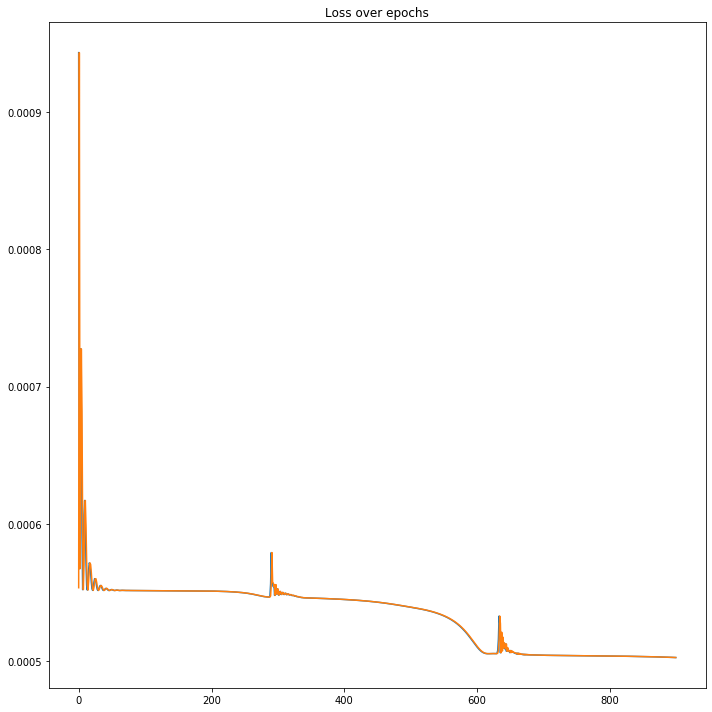

In [28]:
fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
ax.plot(history.history['val_loss'])
ax.plot(history.history['loss'])
ax.set_title('Loss over epochs')
plt.show()

#### Classification Modeling

In [29]:
# Mapping labels to categorical labels
def to_categorical(el):
    if el > 0:
        c = 1
    else:
        c = 0
    return c

y_cls = np.array(list(map(to_categorical, y)))
print('Probability of sampling a 1: {}'.format(y_cls.sum()/len(y_cls)))
print('Probability of sampling a 0: {}'.format((len(y_cls) - y_cls.sum())/len(y_cls)))

Probability of sampling a 1: 0.506
Probability of sampling a 0: 0.494


In [30]:
# Creating a Model and attempting to overfit it
## Defining Model for classification
tf.keras.backend.clear_session()
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
num_features = tf.expand_dims(input_log_returns, -1)
ts_layer_1 = layers.LSTM(500, return_sequences=True)(num_features)
ts_layer_2 = layers.LSTM(500, return_sequences=True)(ts_layer_1)
ts_layer_3 = layers.LSTM(300, return_sequences=True)(ts_layer_2)
ts_layer_4 = layers.LSTM(160, return_sequences=True)(ts_layer_3)
ts_layer_5 = layers.LSTM(50, return_sequences=False)(ts_layer_4)
output = layers.Dense(1, activation='sigmoid')(ts_layer_5)

model = keras.Model(input_log_returns, output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()])
print(model.summary())

history_cls = model.fit(x=X, y=y_cls, batch_size=batch_size, epochs=900, validation_data =(X, y_cls))

Model: "test_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
log_adj_daily_returns (Input [(None, 6)]               0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 6, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 500)            1004000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 500)            2002000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 300)            961200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 6, 160)            295040    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                4

Epoch 29/900
1000/1000 [==============================] - 0s 103us/sample - loss: 0.6931 - binary_accuracy: 0.5060 - precision: 0.5060 - recall: 1.0000 - val_loss: 0.6931 - val_binary_accuracy: 0.5060 - val_precision: 0.5060 - val_recall: 1.0000
Epoch 30/900
1000/1000 [==============================] - 0s 102us/sample - loss: 0.6931 - binary_accuracy: 0.5060 - precision: 0.5060 - recall: 1.0000 - val_loss: 0.6931 - val_binary_accuracy: 0.5060 - val_precision: 0.5060 - val_recall: 1.0000
Epoch 31/900
1000/1000 [==============================] - 0s 101us/sample - loss: 0.6931 - binary_accuracy: 0.5060 - precision: 0.5060 - recall: 1.0000 - val_loss: 0.6931 - val_binary_accuracy: 0.5060 - val_precision: 0.5060 - val_recall: 1.0000
Epoch 32/900
1000/1000 [==============================] - 0s 102us/sample - loss: 0.6931 - binary_accuracy: 0.5060 - precision: 0.5060 - recall: 1.0000 - val_loss: 0.6931 - val_binary_accuracy: 0.5060 - val_precision: 0.5060 - val_recall: 1.0000
Epoch 33/900
100

Epoch 63/900
1000/1000 [==============================] - 0s 105us/sample - loss: 0.6914 - binary_accuracy: 0.5050 - precision: 0.5169 - recall: 0.3320 - val_loss: 0.6911 - val_binary_accuracy: 0.5230 - val_precision: 0.5228 - val_recall: 0.6561
Epoch 64/900
1000/1000 [==============================] - 0s 103us/sample - loss: 0.6911 - binary_accuracy: 0.5230 - precision: 0.5228 - recall: 0.6561 - val_loss: 0.6911 - val_binary_accuracy: 0.5150 - val_precision: 0.5122 - val_recall: 0.8696
Epoch 65/900
1000/1000 [==============================] - 0s 105us/sample - loss: 0.6911 - binary_accuracy: 0.5150 - precision: 0.5122 - recall: 0.8696 - val_loss: 0.6911 - val_binary_accuracy: 0.5150 - val_precision: 0.5118 - val_recall: 0.8992
Epoch 66/900
1000/1000 [==============================] - 0s 103us/sample - loss: 0.6911 - binary_accuracy: 0.5150 - precision: 0.5118 - recall: 0.8992 - val_loss: 0.6907 - val_binary_accuracy: 0.5120 - val_precision: 0.5112 - val_recall: 0.8103
Epoch 67/900
100

Epoch 97/900
1000/1000 [==============================] - 0s 105us/sample - loss: 0.6782 - binary_accuracy: 0.5840 - precision: 0.5991 - recall: 0.5375 - val_loss: 0.6801 - val_binary_accuracy: 0.5470 - val_precision: 0.5381 - val_recall: 0.7391
Epoch 98/900
1000/1000 [==============================] - 0s 105us/sample - loss: 0.6801 - binary_accuracy: 0.5470 - precision: 0.5381 - recall: 0.7391 - val_loss: 0.6779 - val_binary_accuracy: 0.5770 - val_precision: 0.5870 - val_recall: 0.5534
Epoch 99/900
1000/1000 [==============================] - 0s 102us/sample - loss: 0.6779 - binary_accuracy: 0.5770 - precision: 0.5870 - recall: 0.5534 - val_loss: 0.6785 - val_binary_accuracy: 0.5910 - val_precision: 0.6228 - val_recall: 0.4862
Epoch 100/900
1000/1000 [==============================] - 0s 104us/sample - loss: 0.6785 - binary_accuracy: 0.5910 - precision: 0.6228 - recall: 0.4862 - val_loss: 0.6775 - val_binary_accuracy: 0.5730 - val_precision: 0.5727 - val_recall: 0.6146
Epoch 101/900
1

Epoch 131/900
1000/1000 [==============================] - 0s 103us/sample - loss: 0.6727 - binary_accuracy: 0.5680 - precision: 0.5636 - recall: 0.6482 - val_loss: 0.6725 - val_binary_accuracy: 0.5720 - val_precision: 0.5717 - val_recall: 0.6146
Epoch 132/900
1000/1000 [==============================] - 0s 104us/sample - loss: 0.6725 - binary_accuracy: 0.5720 - precision: 0.5717 - recall: 0.6146 - val_loss: 0.6722 - val_binary_accuracy: 0.5720 - val_precision: 0.5641 - val_recall: 0.6779
Epoch 133/900
1000/1000 [==============================] - 0s 103us/sample - loss: 0.6722 - binary_accuracy: 0.5720 - precision: 0.5641 - recall: 0.6779 - val_loss: 0.6720 - val_binary_accuracy: 0.5690 - val_precision: 0.5654 - val_recall: 0.6403
Epoch 134/900
1000/1000 [==============================] - 0s 105us/sample - loss: 0.6720 - binary_accuracy: 0.5690 - precision: 0.5654 - recall: 0.6403 - val_loss: 0.6719 - val_binary_accuracy: 0.5800 - val_precision: 0.5796 - val_recall: 0.6186
Epoch 135/90

Epoch 165/900
1000/1000 [==============================] - 0s 93us/sample - loss: 0.6624 - binary_accuracy: 0.5960 - precision: 0.6016 - recall: 0.5968 - val_loss: 0.6587 - val_binary_accuracy: 0.5890 - val_precision: 0.5832 - val_recall: 0.6581
Epoch 166/900
1000/1000 [==============================] - 0s 99us/sample - loss: 0.6587 - binary_accuracy: 0.5890 - precision: 0.5832 - recall: 0.6581 - val_loss: 0.6603 - val_binary_accuracy: 0.5850 - val_precision: 0.5740 - val_recall: 0.6976
Epoch 167/900
1000/1000 [==============================] - 0s 117us/sample - loss: 0.6603 - binary_accuracy: 0.5850 - precision: 0.5740 - recall: 0.6976 - val_loss: 0.6582 - val_binary_accuracy: 0.6010 - val_precision: 0.6131 - val_recall: 0.5731
Epoch 168/900
1000/1000 [==============================] - 0s 90us/sample - loss: 0.6582 - binary_accuracy: 0.6010 - precision: 0.6131 - recall: 0.5731 - val_loss: 0.6582 - val_binary_accuracy: 0.5830 - val_precision: 0.5728 - val_recall: 0.6917
Epoch 169/900
1

Epoch 199/900
1000/1000 [==============================] - 0s 107us/sample - loss: 0.6353 - binary_accuracy: 0.6080 - precision: 0.5997 - recall: 0.6779 - val_loss: 0.6348 - val_binary_accuracy: 0.6050 - val_precision: 0.6126 - val_recall: 0.5968
Epoch 200/900
1000/1000 [==============================] - 0s 91us/sample - loss: 0.6348 - binary_accuracy: 0.6050 - precision: 0.6126 - recall: 0.5968 - val_loss: 0.6347 - val_binary_accuracy: 0.6050 - val_precision: 0.6188 - val_recall: 0.5711
Epoch 201/900
1000/1000 [==============================] - 0s 96us/sample - loss: 0.6347 - binary_accuracy: 0.6050 - precision: 0.6188 - recall: 0.5711 - val_loss: 0.6327 - val_binary_accuracy: 0.6070 - val_precision: 0.6119 - val_recall: 0.6107
Epoch 202/900
1000/1000 [==============================] - 0s 102us/sample - loss: 0.6327 - binary_accuracy: 0.6070 - precision: 0.6119 - recall: 0.6107 - val_loss: 0.6317 - val_binary_accuracy: 0.6080 - val_precision: 0.6022 - val_recall: 0.6640
Epoch 203/900


Epoch 233/900
1000/1000 [==============================] - 0s 99us/sample - loss: 0.6013 - binary_accuracy: 0.6500 - precision: 0.6773 - recall: 0.5889 - val_loss: 0.6035 - val_binary_accuracy: 0.6460 - val_precision: 0.6234 - val_recall: 0.7589
Epoch 234/900
1000/1000 [==============================] - 0s 93us/sample - loss: 0.6035 - binary_accuracy: 0.6460 - precision: 0.6234 - recall: 0.7589 - val_loss: 0.5999 - val_binary_accuracy: 0.6370 - val_precision: 0.6288 - val_recall: 0.6897
Epoch 235/900
1000/1000 [==============================] - 0s 110us/sample - loss: 0.5999 - binary_accuracy: 0.6370 - precision: 0.6288 - recall: 0.6897 - val_loss: 0.5980 - val_binary_accuracy: 0.6560 - val_precision: 0.7056 - val_recall: 0.5494
Epoch 236/900
1000/1000 [==============================] - 0s 104us/sample - loss: 0.5980 - binary_accuracy: 0.6560 - precision: 0.7056 - recall: 0.5494 - val_loss: 0.5985 - val_binary_accuracy: 0.6590 - val_precision: 0.7177 - val_recall: 0.5375
Epoch 237/900


Epoch 267/900
1000/1000 [==============================] - 0s 99us/sample - loss: 0.5371 - binary_accuracy: 0.7110 - precision: 0.7166 - recall: 0.7095 - val_loss: 0.5336 - val_binary_accuracy: 0.7170 - val_precision: 0.7290 - val_recall: 0.7016
Epoch 268/900
1000/1000 [==============================] - 0s 98us/sample - loss: 0.5336 - binary_accuracy: 0.7170 - precision: 0.7290 - recall: 0.7016 - val_loss: 0.5313 - val_binary_accuracy: 0.7130 - val_precision: 0.7386 - val_recall: 0.6700
Epoch 269/900
1000/1000 [==============================] - 0s 105us/sample - loss: 0.5313 - binary_accuracy: 0.7130 - precision: 0.7386 - recall: 0.6700 - val_loss: 0.5339 - val_binary_accuracy: 0.7200 - val_precision: 0.7116 - val_recall: 0.7510
Epoch 270/900
1000/1000 [==============================] - 0s 105us/sample - loss: 0.5339 - binary_accuracy: 0.7200 - precision: 0.7116 - recall: 0.7510 - val_loss: 0.5614 - val_binary_accuracy: 0.6730 - val_precision: 0.7254 - val_recall: 0.5692
Epoch 271/900


Epoch 301/900
1000/1000 [==============================] - 0s 97us/sample - loss: 0.4296 - binary_accuracy: 0.7850 - precision: 0.7437 - recall: 0.8775 - val_loss: 0.4217 - val_binary_accuracy: 0.7990 - val_precision: 0.8144 - val_recall: 0.7806
Epoch 302/900
1000/1000 [==============================] - 0s 93us/sample - loss: 0.4217 - binary_accuracy: 0.7990 - precision: 0.8144 - recall: 0.7806 - val_loss: 0.4225 - val_binary_accuracy: 0.8170 - val_precision: 0.8473 - val_recall: 0.7787
Epoch 303/900
1000/1000 [==============================] - 0s 104us/sample - loss: 0.4225 - binary_accuracy: 0.8170 - precision: 0.8473 - recall: 0.7787 - val_loss: 0.4045 - val_binary_accuracy: 0.8160 - val_precision: 0.8061 - val_recall: 0.8379
Epoch 304/900
1000/1000 [==============================] - 0s 91us/sample - loss: 0.4045 - binary_accuracy: 0.8160 - precision: 0.8061 - recall: 0.8379 - val_loss: 0.4077 - val_binary_accuracy: 0.8110 - val_precision: 0.8176 - val_recall: 0.8063
Epoch 305/900
1

Epoch 335/900
1000/1000 [==============================] - 0s 110us/sample - loss: 0.2788 - binary_accuracy: 0.8950 - precision: 0.8878 - recall: 0.9071 - val_loss: 0.2793 - val_binary_accuracy: 0.8870 - val_precision: 0.8579 - val_recall: 0.9308
Epoch 336/900
1000/1000 [==============================] - 0s 105us/sample - loss: 0.2793 - binary_accuracy: 0.8870 - precision: 0.8579 - recall: 0.9308 - val_loss: 0.2684 - val_binary_accuracy: 0.8900 - val_precision: 0.9125 - val_recall: 0.8656
Epoch 337/900
1000/1000 [==============================] - 0s 91us/sample - loss: 0.2684 - binary_accuracy: 0.8900 - precision: 0.9125 - recall: 0.8656 - val_loss: 0.2628 - val_binary_accuracy: 0.9010 - val_precision: 0.9046 - val_recall: 0.8992
Epoch 338/900
1000/1000 [==============================] - 0s 108us/sample - loss: 0.2628 - binary_accuracy: 0.9010 - precision: 0.9046 - recall: 0.8992 - val_loss: 0.2578 - val_binary_accuracy: 0.9050 - val_precision: 0.8813 - val_recall: 0.9387
Epoch 339/900

Epoch 369/900
1000/1000 [==============================] - 0s 96us/sample - loss: 0.1622 - binary_accuracy: 0.9550 - precision: 0.9493 - recall: 0.9625 - val_loss: 0.1550 - val_binary_accuracy: 0.9570 - val_precision: 0.9513 - val_recall: 0.9644
Epoch 370/900
1000/1000 [==============================] - 0s 91us/sample - loss: 0.1550 - binary_accuracy: 0.9570 - precision: 0.9513 - recall: 0.9644 - val_loss: 0.1548 - val_binary_accuracy: 0.9590 - val_precision: 0.9568 - val_recall: 0.9625
Epoch 371/900
1000/1000 [==============================] - 0s 100us/sample - loss: 0.1548 - binary_accuracy: 0.9590 - precision: 0.9568 - recall: 0.9625 - val_loss: 0.1477 - val_binary_accuracy: 0.9620 - val_precision: 0.9625 - val_recall: 0.9625
Epoch 372/900
1000/1000 [==============================] - 0s 97us/sample - loss: 0.1477 - binary_accuracy: 0.9620 - precision: 0.9625 - recall: 0.9625 - val_loss: 0.1438 - val_binary_accuracy: 0.9590 - val_precision: 0.9586 - val_recall: 0.9605
Epoch 373/900
1

Epoch 403/900
1000/1000 [==============================] - 0s 88us/sample - loss: 0.1934 - binary_accuracy: 0.9230 - precision: 0.9351 - recall: 0.9111 - val_loss: 0.3141 - val_binary_accuracy: 0.8760 - val_precision: 0.9505 - val_recall: 0.7964
Epoch 404/900
1000/1000 [==============================] - 0s 108us/sample - loss: 0.3141 - binary_accuracy: 0.8760 - precision: 0.9505 - recall: 0.7964 - val_loss: 0.3272 - val_binary_accuracy: 0.8710 - val_precision: 0.7997 - val_recall: 0.9941
Epoch 405/900
1000/1000 [==============================] - 0s 102us/sample - loss: 0.3272 - binary_accuracy: 0.8710 - precision: 0.7997 - recall: 0.9941 - val_loss: 0.2221 - val_binary_accuracy: 0.9080 - val_precision: 0.8935 - val_recall: 0.9289
Epoch 406/900
1000/1000 [==============================] - 0s 90us/sample - loss: 0.2221 - binary_accuracy: 0.9080 - precision: 0.8935 - recall: 0.9289 - val_loss: 0.2248 - val_binary_accuracy: 0.9190 - val_precision: 0.9691 - val_recall: 0.8676
Epoch 407/900


Epoch 437/900
1000/1000 [==============================] - 0s 101us/sample - loss: 0.0406 - binary_accuracy: 0.9980 - precision: 1.0000 - recall: 0.9960 - val_loss: 0.0383 - val_binary_accuracy: 0.9980 - val_precision: 1.0000 - val_recall: 0.9960
Epoch 438/900
1000/1000 [==============================] - 0s 91us/sample - loss: 0.0383 - binary_accuracy: 0.9980 - precision: 1.0000 - recall: 0.9960 - val_loss: 0.0367 - val_binary_accuracy: 0.9980 - val_precision: 1.0000 - val_recall: 0.9960
Epoch 439/900
1000/1000 [==============================] - 0s 92us/sample - loss: 0.0367 - binary_accuracy: 0.9980 - precision: 1.0000 - recall: 0.9960 - val_loss: 0.0358 - val_binary_accuracy: 0.9990 - val_precision: 1.0000 - val_recall: 0.9980
Epoch 440/900
1000/1000 [==============================] - 0s 98us/sample - loss: 0.0358 - binary_accuracy: 0.9990 - precision: 1.0000 - recall: 0.9980 - val_loss: 0.0354 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 441/900
1

Epoch 471/900
1000/1000 [==============================] - 0s 106us/sample - loss: 0.0174 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0171 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 472/900
1000/1000 [==============================] - 0s 92us/sample - loss: 0.0171 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0169 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 473/900
1000/1000 [==============================] - 0s 106us/sample - loss: 0.0169 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0166 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 474/900
1000/1000 [==============================] - 0s 91us/sample - loss: 0.0166 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0163 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 475/900


Epoch 505/900
1000/1000 [==============================] - 0s 100us/sample - loss: 0.0105 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0104 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 506/900
1000/1000 [==============================] - 0s 102us/sample - loss: 0.0104 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0102 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 507/900
1000/1000 [==============================] - 0s 112us/sample - loss: 0.0102 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0101 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 508/900
1000/1000 [==============================] - 0s 90us/sample - loss: 0.0101 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0100 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 509/900

Epoch 539/900
1000/1000 [==============================] - 0s 116us/sample - loss: 0.0072 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0071 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 540/900
1000/1000 [==============================] - 0s 98us/sample - loss: 0.0071 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0071 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 541/900
1000/1000 [==============================] - 0s 108us/sample - loss: 0.0071 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0070 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 542/900
1000/1000 [==============================] - 0s 101us/sample - loss: 0.0070 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0069 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 543/900

Epoch 573/900
1000/1000 [==============================] - 0s 99us/sample - loss: 0.0053 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0053 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 574/900
1000/1000 [==============================] - 0s 110us/sample - loss: 0.0053 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0053 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 575/900
1000/1000 [==============================] - 0s 90us/sample - loss: 0.0053 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0052 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 576/900
1000/1000 [==============================] - 0s 97us/sample - loss: 0.0052 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0052 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 577/900
1

Epoch 607/900
1000/1000 [==============================] - 0s 110us/sample - loss: 0.0042 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0041 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 608/900
1000/1000 [==============================] - 0s 116us/sample - loss: 0.0041 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0041 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 609/900
1000/1000 [==============================] - 0s 130us/sample - loss: 0.0041 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0041 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 610/900
1000/1000 [==============================] - 0s 126us/sample - loss: 0.0041 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0040 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 611/90

Epoch 641/900
1000/1000 [==============================] - 0s 117us/sample - loss: 0.0033 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0033 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 642/900
1000/1000 [==============================] - 0s 122us/sample - loss: 0.0033 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0033 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 643/900
1000/1000 [==============================] - 0s 122us/sample - loss: 0.0033 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0033 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 644/900
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0033 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0033 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 645/90

Epoch 675/900
1000/1000 [==============================] - 0s 113us/sample - loss: 0.0028 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0028 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 676/900
1000/1000 [==============================] - 0s 112us/sample - loss: 0.0028 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0027 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 677/900
1000/1000 [==============================] - 0s 109us/sample - loss: 0.0027 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0027 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 678/900
1000/1000 [==============================] - 0s 113us/sample - loss: 0.0027 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0027 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 679/90

Epoch 709/900
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0023 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0023 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 710/900
1000/1000 [==============================] - 0s 128us/sample - loss: 0.0023 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0023 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 711/900
1000/1000 [==============================] - 0s 116us/sample - loss: 0.0023 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0023 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 712/900
1000/1000 [==============================] - 0s 122us/sample - loss: 0.0023 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0023 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 713/90

Epoch 743/900
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0020 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0020 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 744/900
1000/1000 [==============================] - 0s 119us/sample - loss: 0.0020 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0020 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 745/900
1000/1000 [==============================] - 0s 113us/sample - loss: 0.0020 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0020 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 746/900
1000/1000 [==============================] - 0s 110us/sample - loss: 0.0020 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0020 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 747/90

Epoch 777/900
1000/1000 [==============================] - 0s 114us/sample - loss: 0.0017 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0017 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 778/900
1000/1000 [==============================] - 0s 111us/sample - loss: 0.0017 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0017 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 779/900
1000/1000 [==============================] - 0s 121us/sample - loss: 0.0017 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0017 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 780/900
1000/1000 [==============================] - 0s 118us/sample - loss: 0.0017 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0017 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 781/90

Epoch 811/900
1000/1000 [==============================] - 0s 113us/sample - loss: 0.0015 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0015 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 812/900
1000/1000 [==============================] - 0s 110us/sample - loss: 0.0015 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0015 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 813/900
1000/1000 [==============================] - 0s 108us/sample - loss: 0.0015 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0015 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 814/900
1000/1000 [==============================] - 0s 111us/sample - loss: 0.0015 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0015 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 815/90

Epoch 845/900
1000/1000 [==============================] - 0s 109us/sample - loss: 0.0014 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0014 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 846/900
1000/1000 [==============================] - 0s 110us/sample - loss: 0.0014 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0014 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 847/900
1000/1000 [==============================] - 0s 109us/sample - loss: 0.0014 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0014 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 848/900
1000/1000 [==============================] - 0s 111us/sample - loss: 0.0014 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0013 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 849/90

Epoch 879/900
1000/1000 [==============================] - 0s 110us/sample - loss: 0.0012 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0012 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 880/900
1000/1000 [==============================] - 0s 109us/sample - loss: 0.0012 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0012 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 881/900
1000/1000 [==============================] - 0s 110us/sample - loss: 0.0012 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0012 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 882/900
1000/1000 [==============================] - 0s 108us/sample - loss: 0.0012 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0012 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 883/90

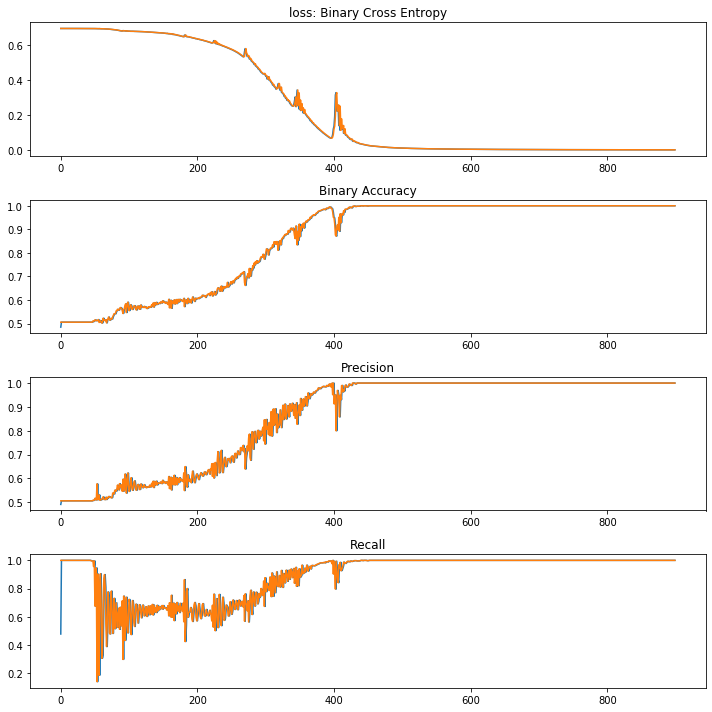

In [31]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), tight_layout=True)
ax[0].plot(history_cls.history['val_loss'])
ax[0].plot(history_cls.history['loss'])
ax[0].set_title('loss: Binary Cross Entropy')
ax[1].plot(history_cls.history['binary_accuracy'])
ax[1].plot(history_cls.history['val_binary_accuracy'])
ax[1].set_title('Binary Accuracy')
ax[2].plot(history_cls.history['precision'])
ax[2].plot(history_cls.history['val_precision'])
ax[2].set_title('Precision')
ax[3].plot(history_cls.history['recall'])
ax[3].plot(history_cls.history['val_recall'])
ax[3].set_title('Recall')
plt.show()

### Using only pricing data from all tickers

In [32]:
# Hyperparameters
dataset_size_by_ticker = [200, 100, 50, 300]
batch_size = 650
assert batch_size == sum(dataset_size_by_ticker)

preprocessed_df = pd.read_csv(os.path.join(path_to_data, 'preprocessed.csv'), parse_dates=['timestamp'])

features_to_test = ['log_adj_daily_returns']
data_df = preprocessed_df[['timestamp'] + ['_'.join([feature, t]) for t in tickers for feature in features_to_test]]
data_df.head(8)

,timestamp,log_adj_daily_returns_WFC,log_adj_daily_returns_JPM,log_adj_daily_returns_BAC,log_adj_daily_returns_C
0,2019-10-22,0.003166,0.009986,0.005786,0.003475
1,2019-10-21,0.009758,0.024498,0.021836,0.029250
2,2019-10-18,0.007230,0.001743,0.002970,0.002009
3,2019-10-17,0.000403,0.005583,0.002979,0.001438
4,2019-10-16,-0.010431,-0.002337,0.014691,-0.024447
5,2019-10-15,0.016905,0.029696,0.020045,0.013856
6,2019-10-14,0.001219,0.002666,0.007924,0.001995
7,2019-10-11,0.011445,0.016758,0.016039,0.021339


In [33]:
df = to_time_series(data_df, data_df.columns, n_trail=5)
df.head()

,timestamp(t-5),log_adj_daily_returns_WFC(t-5),log_adj_daily_returns_JPM(t-5),log_adj_daily_returns_BAC(t-5),log_adj_daily_returns_C(t-5),timestamp(t-4),log_adj_daily_returns_WFC(t-4),log_adj_daily_returns_JPM(t-4),log_adj_daily_returns_BAC(t-4),log_adj_daily_returns_C(t-4),...,timestamp(t+0),log_adj_daily_returns_WFC(t+0),log_adj_daily_returns_JPM(t+0),log_adj_daily_returns_BAC(t+0),log_adj_daily_returns_C(t+0),timestamp(t+1),log_adj_daily_returns_WFC(t+1),log_adj_daily_returns_JPM(t+1),log_adj_daily_returns_BAC(t+1),log_adj_daily_returns_C(t+1)
1,2019-10-14,0.001219,0.002666,0.007924,0.001995,2019-10-15,0.016905,0.029696,0.020045,0.013856,...,2019-10-21,0.009758,0.024498,0.021836,0.029250,2019-10-22,0.003166,0.009986,0.005786,0.003475
2,2019-10-11,0.011445,0.016758,0.016039,0.021339,2019-10-14,0.001219,0.002666,0.007924,0.001995,...,2019-10-18,0.007230,0.001743,0.002970,0.002009,2019-10-21,0.009758,0.024498,0.021836,0.029250
3,2019-10-10,0.010331,0.013931,0.019880,0.017494,2019-10-11,0.011445,0.016758,0.016039,0.021339,...,2019-10-17,0.000403,0.005583,0.002979,0.001438,2019-10-18,0.007230,0.001743,0.002970,0.002009
4,2019-10-09,0.006877,0.007218,0.009366,0.015393,2019-10-10,0.010331,0.013931,0.019880,0.017494,...,2019-10-16,-0.010431,-0.002337,0.014691,-0.024447,2019-10-17,0.000403,0.005583,0.002979,0.001438
5,2019-10-08,-0.020491,-0.022548,-0.024313,-0.026014,2019-10-09,0.006877,0.007218,0.009366,0.015393,...,2019-10-15,0.016905,0.029696,0.020045,0.013856,2019-10-16,-0.010431,-0.002337,0.014691,-0.024447


In [34]:
column_names_by_ticker = [[name for name in df.columns if 'log_adj_daily_returns_' + t in name] for t in tickers]
print(column_names_by_ticker)

[['log_adj_daily_returns_WFC(t-5)', 'log_adj_daily_returns_WFC(t-4)', 'log_adj_daily_returns_WFC(t-3)', 'log_adj_daily_returns_WFC(t-2)', 'log_adj_daily_returns_WFC(t-1)', 'log_adj_daily_returns_WFC(t+0)', 'log_adj_daily_returns_WFC(t+1)'], ['log_adj_daily_returns_JPM(t-5)', 'log_adj_daily_returns_JPM(t-4)', 'log_adj_daily_returns_JPM(t-3)', 'log_adj_daily_returns_JPM(t-2)', 'log_adj_daily_returns_JPM(t-1)', 'log_adj_daily_returns_JPM(t+0)', 'log_adj_daily_returns_JPM(t+1)'], ['log_adj_daily_returns_BAC(t-5)', 'log_adj_daily_returns_BAC(t-4)', 'log_adj_daily_returns_BAC(t-3)', 'log_adj_daily_returns_BAC(t-2)', 'log_adj_daily_returns_BAC(t-1)', 'log_adj_daily_returns_BAC(t+0)', 'log_adj_daily_returns_BAC(t+1)'], ['log_adj_daily_returns_C(t-5)', 'log_adj_daily_returns_C(t-4)', 'log_adj_daily_returns_C(t-3)', 'log_adj_daily_returns_C(t-2)', 'log_adj_daily_returns_C(t-1)', 'log_adj_daily_returns_C(t+0)', 'log_adj_daily_returns_C(t+1)']]


In [35]:
dfs = list(map(lambda cols: df[cols], column_names_by_ticker))

In [36]:
# Checking dfs
for el in dfs:
    print(el.head())
    print()
    print()
    print()
    print()

   log_adj_daily_returns_WFC(t-5)  log_adj_daily_returns_WFC(t-4)  \
1                        0.001219                        0.016905   
2                        0.011445                        0.001219   
3                        0.010331                        0.011445   
4                        0.006877                        0.010331   
5                       -0.020491                        0.006877   

   log_adj_daily_returns_WFC(t-3)  log_adj_daily_returns_WFC(t-2)  \
1                       -0.010431                        0.000403   
2                        0.016905                       -0.010431   
3                        0.001219                        0.016905   
4                        0.011445                        0.001219   
5                        0.010331                        0.011445   

   log_adj_daily_returns_WFC(t-1)  log_adj_daily_returns_WFC(t+0)  \
1                        0.007230                        0.009758   
2                        0.00040

In [37]:
datasets_by_ticker = list(map(lambda d: d.values, dfs))

In [38]:
print('Number of datasets: {}'.format(len(datasets_by_ticker)))
print('Shape of each dataset: {}'.format(list(map(lambda d: d.shape, datasets_by_ticker))))

Number of datasets: 4
Shape of each dataset: [(5024, 7), (5024, 7), (5024, 7), (5024, 7)]


In [39]:
# Shuffling and Sampling Datasets
shuffled_indices_per_ticker = [np.random.choice(len(datasets_by_ticker[i]),
                                                size=dataset_size_by_ticker[i],
                                                replace=False)
                               for i in range(len(dataset_size_by_ticker))]
print('Number of samples for each ticker: {}'.format(list(map(len, shuffled_indices_per_ticker))))
sampled_datasets_by_ticker = [datasets_by_ticker[i][shuffled_indices_per_ticker[i]] for i in range(len(datasets_by_ticker))]
print('Shape of each sampled dataset: {}'.format(list(map(lambda d: d.shape, sampled_datasets_by_ticker))))

Number of samples for each ticker: [200, 100, 50, 300]
Shape of each sampled dataset: [(200, 7), (100, 7), (50, 7), (300, 7)]


In [40]:
# Concatenating datasets
dataset = np.concatenate(sampled_datasets_by_ticker, axis=0)
print('Shape of dataset: {}'.format(dataset.shape))

Shape of dataset: (650, 7)


In [41]:
# Shuffling merged dataset
shuffle_indices = np.random.randint(len(dataset), size=len(dataset))
assert len(shuffle_indices) == len(dataset)
print(shuffle_indices)
shuffled_dataset = dataset[shuffle_indices]

[161 521 569 584 609 256 218  17 513 207 584 503 547 157 253  21 565 589
 107 533 490  32 189 399  22 104 197  23 491 255   5  91 435 105 323 198
 607 406 383 591 329 255 514 497  30 624 575  41 573  66  36 279 630 261
 373 618 574 129 504 531 524  68 363 100 145  95 166 156 525 585 459 162
 346 194 173 157 353  55 357 478  96 521 395 131 222  94 514 437 433 104
 306  90 602 560 175 347 151 644 152 455  97 634  92 194 231 495 529 557
 166 189 286 311  58 290 238 549 430 599 509 171 216  73 601 541 600 106
 542 310 466 232 479 279 300 305 635 263 383 389 555  70 250 350 424 121
 391 111 495  98 147  18 173 454  64 148 553 584 626 423 555 431 141 362
  42 239  79 282 123 592  17 632 321 334  87 562 327 337 569 329 116 158
 517 258 381 624 597 151 450 487 546 113 406 542  13 261 138 350 301 379
 521  60 410 368 595 123 212 577 485 367 378 505 500 548 112 544 614 446
 520 112 375 297 249 596 483 186 616 194 243 534 583 216 240 496 363 572
 527 624 278 151 423 649 354 281 635 511 131 583 45

In [42]:
# Spliting Dataset into Features and Labels
X, y = shuffled_dataset[:, :-1], shuffled_dataset[:, -1]
print('Shape of features: {}'.format(X.shape))
print('Shape of targets: {}'.format(y.shape))

Shape of features: (650, 6)
Shape of targets: (650,)


#### Regression Modeling

In [43]:
# Creating a Model and attempting to overfit it
## Defining Model
tf.keras.backend.clear_session()
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
num_features = tf.expand_dims(input_log_returns, -1)
ts_layer_1 = layers.LSTM(500, return_sequences=True)(num_features)
ts_layer_2 = layers.LSTM(500, return_sequences=True)(ts_layer_1)
ts_layer_3 = layers.LSTM(300, return_sequences=True)(ts_layer_2)
ts_layer_4 = layers.LSTM(160, return_sequences=True)(ts_layer_3)
ts_layer_5 = layers.LSTM(50, return_sequences=False)(ts_layer_4)
output = layers.Dense(1)(ts_layer_5)
model = keras.Model(input_log_returns, output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=None)
print(model.summary())

history = model.fit(x=X, y=y, batch_size=batch_size, epochs=900, validation_data =(X, y))

Model: "test_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
log_adj_daily_returns (Input [(None, 6)]               0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 6, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 500)            1004000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 500)            2002000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 300)            961200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 6, 160)            295040    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                4

Epoch 61/900
650/650 [==============================] - 0s 98us/sample - loss: 7.4886e-04 - val_loss: 7.4877e-04
Epoch 62/900
650/650 [==============================] - 0s 98us/sample - loss: 7.4877e-04 - val_loss: 7.4873e-04
Epoch 63/900
650/650 [==============================] - 0s 101us/sample - loss: 7.4873e-04 - val_loss: 7.4874e-04
Epoch 64/900
650/650 [==============================] - 0s 104us/sample - loss: 7.4874e-04 - val_loss: 7.4878e-04
Epoch 65/900
650/650 [==============================] - 0s 100us/sample - loss: 7.4878e-04 - val_loss: 7.4881e-04
Epoch 66/900
650/650 [==============================] - 0s 100us/sample - loss: 7.4881e-04 - val_loss: 7.4880e-04
Epoch 67/900
650/650 [==============================] - 0s 101us/sample - loss: 7.4880e-04 - val_loss: 7.4876e-04
Epoch 68/900
650/650 [==============================] - 0s 99us/sample - loss: 7.4876e-04 - val_loss: 7.4871e-04
Epoch 69/900
650/650 [==============================] - 0s 98us/sample - loss: 7.4871e-04 -

Epoch 133/900
650/650 [==============================] - 0s 101us/sample - loss: 7.4522e-04 - val_loss: 7.4501e-04
Epoch 134/900
650/650 [==============================] - 0s 102us/sample - loss: 7.4501e-04 - val_loss: 7.4479e-04
Epoch 135/900
650/650 [==============================] - 0s 100us/sample - loss: 7.4479e-04 - val_loss: 7.4455e-04
Epoch 136/900
650/650 [==============================] - 0s 99us/sample - loss: 7.4455e-04 - val_loss: 7.4430e-04
Epoch 137/900
650/650 [==============================] - 0s 98us/sample - loss: 7.4430e-04 - val_loss: 7.4403e-04
Epoch 138/900
650/650 [==============================] - 0s 102us/sample - loss: 7.4403e-04 - val_loss: 7.4375e-04
Epoch 139/900
650/650 [==============================] - 0s 99us/sample - loss: 7.4375e-04 - val_loss: 7.4344e-04
Epoch 140/900
650/650 [==============================] - 0s 109us/sample - loss: 7.4344e-04 - val_loss: 7.4311e-04
Epoch 141/900
650/650 [==============================] - 0s 102us/sample - loss: 7.

Epoch 205/900
650/650 [==============================] - 0s 100us/sample - loss: 7.3140e-04 - val_loss: 7.3139e-04
Epoch 206/900
650/650 [==============================] - 0s 102us/sample - loss: 7.3139e-04 - val_loss: 7.3110e-04
Epoch 207/900
650/650 [==============================] - 0s 101us/sample - loss: 7.3110e-04 - val_loss: 7.3099e-04
Epoch 208/900
650/650 [==============================] - 0s 104us/sample - loss: 7.3099e-04 - val_loss: 7.3087e-04
Epoch 209/900
650/650 [==============================] - 0s 100us/sample - loss: 7.3087e-04 - val_loss: 7.3062e-04
Epoch 210/900
650/650 [==============================] - 0s 101us/sample - loss: 7.3062e-04 - val_loss: 7.3056e-04
Epoch 211/900
650/650 [==============================] - 0s 102us/sample - loss: 7.3056e-04 - val_loss: 7.3035e-04
Epoch 212/900
650/650 [==============================] - 0s 101us/sample - loss: 7.3035e-04 - val_loss: 7.3019e-04
Epoch 213/900
650/650 [==============================] - 0s 106us/sample - loss:

Epoch 277/900
650/650 [==============================] - 0s 102us/sample - loss: 7.1551e-04 - val_loss: 7.1553e-04
Epoch 278/900
650/650 [==============================] - 0s 101us/sample - loss: 7.1553e-04 - val_loss: 7.1555e-04
Epoch 279/900
650/650 [==============================] - 0s 102us/sample - loss: 7.1555e-04 - val_loss: 7.1555e-04
Epoch 280/900
650/650 [==============================] - 0s 101us/sample - loss: 7.1555e-04 - val_loss: 7.1555e-04
Epoch 281/900
650/650 [==============================] - 0s 102us/sample - loss: 7.1555e-04 - val_loss: 7.1554e-04
Epoch 282/900
650/650 [==============================] - 0s 101us/sample - loss: 7.1554e-04 - val_loss: 7.1552e-04
Epoch 283/900
650/650 [==============================] - 0s 103us/sample - loss: 7.1552e-04 - val_loss: 7.1550e-04
Epoch 284/900
650/650 [==============================] - 0s 101us/sample - loss: 7.1550e-04 - val_loss: 7.1547e-04
Epoch 285/900
650/650 [==============================] - 0s 103us/sample - loss:

Epoch 349/900
650/650 [==============================] - 0s 109us/sample - loss: 7.1518e-04 - val_loss: 7.1518e-04
Epoch 350/900
650/650 [==============================] - 0s 111us/sample - loss: 7.1518e-04 - val_loss: 7.1517e-04
Epoch 351/900
650/650 [==============================] - 0s 112us/sample - loss: 7.1517e-04 - val_loss: 7.1517e-04
Epoch 352/900
650/650 [==============================] - 0s 115us/sample - loss: 7.1517e-04 - val_loss: 7.1517e-04
Epoch 353/900
650/650 [==============================] - 0s 111us/sample - loss: 7.1517e-04 - val_loss: 7.1517e-04
Epoch 354/900
650/650 [==============================] - 0s 112us/sample - loss: 7.1517e-04 - val_loss: 7.1516e-04
Epoch 355/900
650/650 [==============================] - 0s 112us/sample - loss: 7.1516e-04 - val_loss: 7.1516e-04
Epoch 356/900
650/650 [==============================] - 0s 112us/sample - loss: 7.1516e-04 - val_loss: 7.1516e-04
Epoch 357/900
650/650 [==============================] - 0s 115us/sample - loss:

Epoch 421/900
650/650 [==============================] - 0s 122us/sample - loss: 7.1500e-04 - val_loss: 7.1500e-04
Epoch 422/900
650/650 [==============================] - 0s 120us/sample - loss: 7.1500e-04 - val_loss: 7.1499e-04
Epoch 423/900
650/650 [==============================] - 0s 123us/sample - loss: 7.1499e-04 - val_loss: 7.1499e-04
Epoch 424/900
650/650 [==============================] - 0s 120us/sample - loss: 7.1499e-04 - val_loss: 7.1499e-04
Epoch 425/900
650/650 [==============================] - 0s 121us/sample - loss: 7.1499e-04 - val_loss: 7.1499e-04
Epoch 426/900
650/650 [==============================] - 0s 121us/sample - loss: 7.1499e-04 - val_loss: 7.1498e-04
Epoch 427/900
650/650 [==============================] - 0s 122us/sample - loss: 7.1498e-04 - val_loss: 7.1498e-04
Epoch 428/900
650/650 [==============================] - 0s 122us/sample - loss: 7.1498e-04 - val_loss: 7.1498e-04
Epoch 429/900
650/650 [==============================] - 0s 119us/sample - loss:

Epoch 493/900
650/650 [==============================] - 0s 122us/sample - loss: 7.1481e-04 - val_loss: 7.1480e-04
Epoch 494/900
650/650 [==============================] - 0s 122us/sample - loss: 7.1480e-04 - val_loss: 7.1480e-04
Epoch 495/900
650/650 [==============================] - 0s 123us/sample - loss: 7.1480e-04 - val_loss: 7.1480e-04
Epoch 496/900
650/650 [==============================] - 0s 123us/sample - loss: 7.1480e-04 - val_loss: 7.1480e-04
Epoch 497/900
650/650 [==============================] - 0s 124us/sample - loss: 7.1480e-04 - val_loss: 7.1479e-04
Epoch 498/900
650/650 [==============================] - 0s 124us/sample - loss: 7.1479e-04 - val_loss: 7.1479e-04
Epoch 499/900
650/650 [==============================] - 0s 121us/sample - loss: 7.1479e-04 - val_loss: 7.1479e-04
Epoch 500/900
650/650 [==============================] - 0s 123us/sample - loss: 7.1479e-04 - val_loss: 7.1478e-04
Epoch 501/900
650/650 [==============================] - 0s 120us/sample - loss:

Epoch 565/900
650/650 [==============================] - 0s 119us/sample - loss: 7.1459e-04 - val_loss: 7.1458e-04
Epoch 566/900
650/650 [==============================] - 0s 120us/sample - loss: 7.1458e-04 - val_loss: 7.1458e-04
Epoch 567/900
650/650 [==============================] - 0s 123us/sample - loss: 7.1458e-04 - val_loss: 7.1458e-04
Epoch 568/900
650/650 [==============================] - 0s 120us/sample - loss: 7.1458e-04 - val_loss: 7.1457e-04
Epoch 569/900
650/650 [==============================] - 0s 119us/sample - loss: 7.1457e-04 - val_loss: 7.1457e-04
Epoch 570/900
650/650 [==============================] - 0s 121us/sample - loss: 7.1457e-04 - val_loss: 7.1457e-04
Epoch 571/900
650/650 [==============================] - 0s 119us/sample - loss: 7.1457e-04 - val_loss: 7.1456e-04
Epoch 572/900
650/650 [==============================] - 0s 120us/sample - loss: 7.1456e-04 - val_loss: 7.1456e-04
Epoch 573/900
650/650 [==============================] - 0s 122us/sample - loss:

Epoch 637/900
650/650 [==============================] - 0s 119us/sample - loss: 7.1431e-04 - val_loss: 7.1431e-04
Epoch 638/900
650/650 [==============================] - 0s 120us/sample - loss: 7.1431e-04 - val_loss: 7.1431e-04
Epoch 639/900
650/650 [==============================] - 0s 123us/sample - loss: 7.1431e-04 - val_loss: 7.1430e-04
Epoch 640/900
650/650 [==============================] - 0s 120us/sample - loss: 7.1430e-04 - val_loss: 7.1430e-04
Epoch 641/900
650/650 [==============================] - 0s 125us/sample - loss: 7.1430e-04 - val_loss: 7.1429e-04
Epoch 642/900
650/650 [==============================] - 0s 126us/sample - loss: 7.1429e-04 - val_loss: 7.1429e-04
Epoch 643/900
650/650 [==============================] - 0s 126us/sample - loss: 7.1429e-04 - val_loss: 7.1428e-04
Epoch 644/900
650/650 [==============================] - 0s 133us/sample - loss: 7.1428e-04 - val_loss: 7.1428e-04
Epoch 645/900
650/650 [==============================] - 0s 132us/sample - loss:

Epoch 709/900
650/650 [==============================] - 0s 119us/sample - loss: 7.1393e-04 - val_loss: 7.1393e-04
Epoch 710/900
650/650 [==============================] - 0s 121us/sample - loss: 7.1393e-04 - val_loss: 7.1392e-04
Epoch 711/900
650/650 [==============================] - 0s 123us/sample - loss: 7.1392e-04 - val_loss: 7.1391e-04
Epoch 712/900
650/650 [==============================] - 0s 123us/sample - loss: 7.1391e-04 - val_loss: 7.1391e-04
Epoch 713/900
650/650 [==============================] - 0s 122us/sample - loss: 7.1391e-04 - val_loss: 7.1390e-04
Epoch 714/900
650/650 [==============================] - 0s 119us/sample - loss: 7.1390e-04 - val_loss: 7.1389e-04
Epoch 715/900
650/650 [==============================] - 0s 120us/sample - loss: 7.1389e-04 - val_loss: 7.1388e-04
Epoch 716/900
650/650 [==============================] - 0s 124us/sample - loss: 7.1388e-04 - val_loss: 7.1388e-04
Epoch 717/900
650/650 [==============================] - 0s 118us/sample - loss:

Epoch 781/900
650/650 [==============================] - 0s 122us/sample - loss: 7.1326e-04 - val_loss: 7.1324e-04
Epoch 782/900
650/650 [==============================] - 0s 120us/sample - loss: 7.1324e-04 - val_loss: 7.1323e-04
Epoch 783/900
650/650 [==============================] - 0s 122us/sample - loss: 7.1323e-04 - val_loss: 7.1321e-04
Epoch 784/900
650/650 [==============================] - 0s 122us/sample - loss: 7.1321e-04 - val_loss: 7.1320e-04
Epoch 785/900
650/650 [==============================] - 0s 123us/sample - loss: 7.1320e-04 - val_loss: 7.1318e-04
Epoch 786/900
650/650 [==============================] - 0s 123us/sample - loss: 7.1318e-04 - val_loss: 7.1317e-04
Epoch 787/900
650/650 [==============================] - 0s 121us/sample - loss: 7.1317e-04 - val_loss: 7.1315e-04
Epoch 788/900
650/650 [==============================] - 0s 120us/sample - loss: 7.1315e-04 - val_loss: 7.1313e-04
Epoch 789/900
650/650 [==============================] - 0s 120us/sample - loss:

Epoch 853/900
650/650 [==============================] - 0s 120us/sample - loss: 7.0525e-04 - val_loss: 7.0390e-04
Epoch 854/900
650/650 [==============================] - 0s 120us/sample - loss: 7.0390e-04 - val_loss: 7.0216e-04
Epoch 855/900
650/650 [==============================] - 0s 118us/sample - loss: 7.0216e-04 - val_loss: 6.9994e-04
Epoch 856/900
650/650 [==============================] - 0s 121us/sample - loss: 6.9994e-04 - val_loss: 6.9707e-04
Epoch 857/900
650/650 [==============================] - 0s 118us/sample - loss: 6.9707e-04 - val_loss: 6.9344e-04
Epoch 858/900
650/650 [==============================] - 0s 121us/sample - loss: 6.9344e-04 - val_loss: 6.8894e-04
Epoch 859/900
650/650 [==============================] - 0s 121us/sample - loss: 6.8894e-04 - val_loss: 6.8372e-04
Epoch 860/900
650/650 [==============================] - 0s 119us/sample - loss: 6.8372e-04 - val_loss: 6.7852e-04
Epoch 861/900
650/650 [==============================] - 0s 122us/sample - loss:

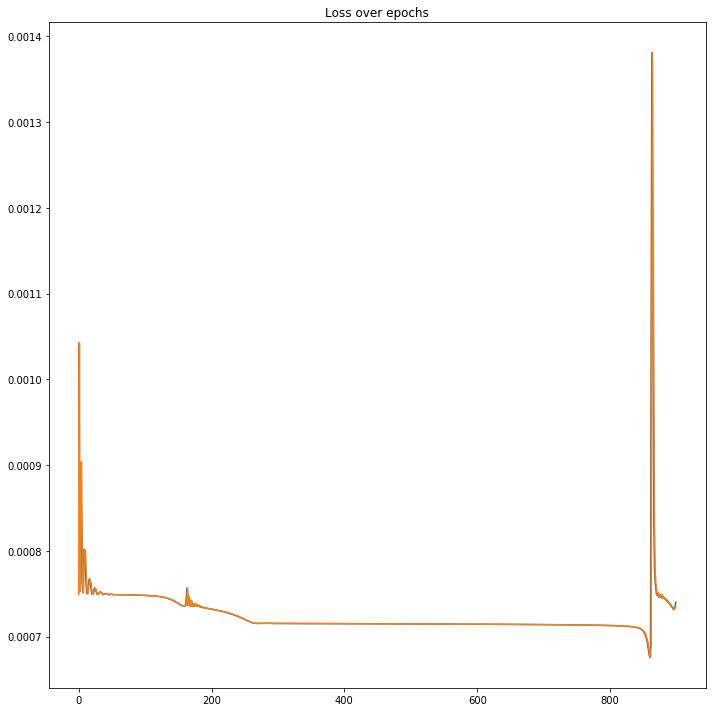

In [44]:
fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
ax.plot(history.history['val_loss'])
ax.plot(history.history['loss'])
ax.set_title('Loss over epochs')
plt.show()

#### Classification Modeling

In [45]:
# Mapping labels to categorical labels
def to_categorical(el):
    if el > 0:
        c = 1
    else:
        c = 0
    return c

y_cls = np.array(list(map(to_categorical, y)))
print('Probability of sampling a 1: {}'.format(y_cls.sum()/len(y_cls)))
print('Probability of sampling a 0: {}'.format((len(y_cls) - y_cls.sum())/len(y_cls)))

Probability of sampling a 1: 0.4553846153846154
Probability of sampling a 0: 0.5446153846153846


In [46]:
# Creating a Model and attempting to overfit it
## Defining Model for classification
tf.keras.backend.clear_session()
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
num_features = tf.expand_dims(input_log_returns, -1)
ts_layer_1 = layers.LSTM(500, return_sequences=True)(num_features)
ts_layer_2 = layers.LSTM(500, return_sequences=True)(ts_layer_1)
ts_layer_3 = layers.LSTM(300, return_sequences=True)(ts_layer_2)
ts_layer_4 = layers.LSTM(160, return_sequences=True)(ts_layer_3)
ts_layer_5 = layers.LSTM(50, return_sequences=False)(ts_layer_4)
output = layers.Dense(1, activation='sigmoid')(ts_layer_5)

model = keras.Model(input_log_returns, output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()])
print(model.summary())

history_cls = model.fit(x=X, y=y_cls, batch_size=batch_size, epochs=900, validation_data =(X, y_cls))

Model: "test_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
log_adj_daily_returns (Input [(None, 6)]               0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 6, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 500)            1004000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 500)            2002000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 300)            961200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 6, 160)            295040    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                4

Epoch 27/900
650/650 [==============================] - 0s 120us/sample - loss: 0.6892 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6892 - val_binary_accuracy: 0.5446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 28/900
650/650 [==============================] - 0s 117us/sample - loss: 0.6892 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6892 - val_binary_accuracy: 0.5446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 29/900
650/650 [==============================] - 0s 117us/sample - loss: 0.6892 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6892 - val_binary_accuracy: 0.5446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 30/900
650/650 [==============================] - 0s 110us/sample - loss: 0.6892 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6892 - val_binary_accuracy: 0.5446 - val_precisi

Epoch 59/900
650/650 [==============================] - 0s 117us/sample - loss: 0.6892 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6892 - val_binary_accuracy: 0.5446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 60/900
650/650 [==============================] - 0s 111us/sample - loss: 0.6892 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6892 - val_binary_accuracy: 0.5446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 61/900
650/650 [==============================] - 0s 107us/sample - loss: 0.6892 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6892 - val_binary_accuracy: 0.5446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 62/900
650/650 [==============================] - 0s 119us/sample - loss: 0.6892 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6892 - val_binary_accuracy: 0.5446 - val_precisi

Epoch 91/900
650/650 [==============================] - 0s 100us/sample - loss: 0.6891 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6891 - val_binary_accuracy: 0.5446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 92/900
650/650 [==============================] - 0s 109us/sample - loss: 0.6891 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6891 - val_binary_accuracy: 0.5446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 93/900
650/650 [==============================] - 0s 126us/sample - loss: 0.6891 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6891 - val_binary_accuracy: 0.5446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 94/900
650/650 [==============================] - 0s 122us/sample - loss: 0.6891 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6891 - val_binary_accuracy: 0.5446 - val_precisi

Epoch 123/900
650/650 [==============================] - 0s 120us/sample - loss: 0.6891 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6890 - val_binary_accuracy: 0.5446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 124/900
650/650 [==============================] - 0s 121us/sample - loss: 0.6890 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6890 - val_binary_accuracy: 0.5446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 125/900
650/650 [==============================] - 0s 113us/sample - loss: 0.6890 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6890 - val_binary_accuracy: 0.5446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 126/900
650/650 [==============================] - 0s 114us/sample - loss: 0.6890 - binary_accuracy: 0.5446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6890 - val_binary_accuracy: 0.5446 - val_pre

Epoch 157/900
650/650 [==============================] - 0s 103us/sample - loss: 0.6864 - binary_accuracy: 0.5600 - precision: 0.6667 - recall: 0.0676 - val_loss: 0.6863 - val_binary_accuracy: 0.5646 - val_precision: 0.7241 - val_recall: 0.0709
Epoch 158/900
650/650 [==============================] - 0s 113us/sample - loss: 0.6863 - binary_accuracy: 0.5646 - precision: 0.7241 - recall: 0.0709 - val_loss: 0.6862 - val_binary_accuracy: 0.5492 - val_precision: 0.5789 - val_recall: 0.0372
Epoch 159/900
650/650 [==============================] - 0s 123us/sample - loss: 0.6862 - binary_accuracy: 0.5492 - precision: 0.5789 - recall: 0.0372 - val_loss: 0.6861 - val_binary_accuracy: 0.5462 - val_precision: 0.5455 - val_recall: 0.0203
Epoch 160/900
650/650 [==============================] - 0s 119us/sample - loss: 0.6861 - binary_accuracy: 0.5462 - precision: 0.5455 - recall: 0.0203 - val_loss: 0.6861 - val_binary_accuracy: 0.5431 - val_precision: 0.4444 - val_recall: 0.0135
Epoch 161/900
650/65

Epoch 191/900
650/650 [==============================] - 0s 121us/sample - loss: 0.6824 - binary_accuracy: 0.5477 - precision: 0.6250 - recall: 0.0169 - val_loss: 0.6875 - val_binary_accuracy: 0.5738 - val_precision: 0.7568 - val_recall: 0.0946
Epoch 192/900
650/650 [==============================] - 0s 112us/sample - loss: 0.6875 - binary_accuracy: 0.5738 - precision: 0.7568 - recall: 0.0946 - val_loss: 0.6830 - val_binary_accuracy: 0.5477 - val_precision: 0.6667 - val_recall: 0.0135
Epoch 193/900
650/650 [==============================] - 0s 110us/sample - loss: 0.6830 - binary_accuracy: 0.5477 - precision: 0.6667 - recall: 0.0135 - val_loss: 0.6889 - val_binary_accuracy: 0.5508 - val_precision: 0.8333 - val_recall: 0.0169
Epoch 194/900
650/650 [==============================] - 0s 116us/sample - loss: 0.6889 - binary_accuracy: 0.5508 - precision: 0.8333 - recall: 0.0169 - val_loss: 0.6814 - val_binary_accuracy: 0.5492 - val_precision: 0.7143 - val_recall: 0.0169
Epoch 195/900
650/65

Epoch 225/900
650/650 [==============================] - 0s 118us/sample - loss: 0.6804 - binary_accuracy: 0.5492 - precision: 0.7143 - recall: 0.0169 - val_loss: 0.6804 - val_binary_accuracy: 0.5492 - val_precision: 0.7143 - val_recall: 0.0169
Epoch 226/900
650/650 [==============================] - 0s 103us/sample - loss: 0.6804 - binary_accuracy: 0.5492 - precision: 0.7143 - recall: 0.0169 - val_loss: 0.6804 - val_binary_accuracy: 0.5492 - val_precision: 0.7143 - val_recall: 0.0169
Epoch 227/900
650/650 [==============================] - 0s 112us/sample - loss: 0.6804 - binary_accuracy: 0.5492 - precision: 0.7143 - recall: 0.0169 - val_loss: 0.6804 - val_binary_accuracy: 0.5492 - val_precision: 0.7143 - val_recall: 0.0169
Epoch 228/900
650/650 [==============================] - 0s 121us/sample - loss: 0.6804 - binary_accuracy: 0.5492 - precision: 0.7143 - recall: 0.0169 - val_loss: 0.6803 - val_binary_accuracy: 0.5492 - val_precision: 0.7143 - val_recall: 0.0169
Epoch 229/900
650/65

Epoch 259/900
650/650 [==============================] - 0s 119us/sample - loss: 0.6769 - binary_accuracy: 0.5615 - precision: 0.6571 - recall: 0.0777 - val_loss: 0.6763 - val_binary_accuracy: 0.5662 - val_precision: 0.6944 - val_recall: 0.0845
Epoch 260/900
650/650 [==============================] - 0s 119us/sample - loss: 0.6763 - binary_accuracy: 0.5662 - precision: 0.6944 - recall: 0.0845 - val_loss: 0.6769 - val_binary_accuracy: 0.5815 - val_precision: 0.7000 - val_recall: 0.1419
Epoch 261/900
650/650 [==============================] - 0s 117us/sample - loss: 0.6769 - binary_accuracy: 0.5815 - precision: 0.7000 - recall: 0.1419 - val_loss: 0.6769 - val_binary_accuracy: 0.5554 - val_precision: 0.5507 - val_recall: 0.1284
Epoch 262/900
650/650 [==============================] - 0s 107us/sample - loss: 0.6769 - binary_accuracy: 0.5554 - precision: 0.5507 - recall: 0.1284 - val_loss: 0.6829 - val_binary_accuracy: 0.5462 - val_precision: 0.5028 - val_recall: 0.3007
Epoch 263/900
650/65

Epoch 293/900
650/650 [==============================] - 0s 95us/sample - loss: 0.6798 - binary_accuracy: 0.5523 - precision: 1.0000 - recall: 0.0169 - val_loss: 0.6797 - val_binary_accuracy: 0.5523 - val_precision: 1.0000 - val_recall: 0.0169
Epoch 294/900
650/650 [==============================] - 0s 131us/sample - loss: 0.6797 - binary_accuracy: 0.5523 - precision: 1.0000 - recall: 0.0169 - val_loss: 0.6796 - val_binary_accuracy: 0.5523 - val_precision: 1.0000 - val_recall: 0.0169
Epoch 295/900
650/650 [==============================] - 0s 120us/sample - loss: 0.6796 - binary_accuracy: 0.5523 - precision: 1.0000 - recall: 0.0169 - val_loss: 0.6795 - val_binary_accuracy: 0.5523 - val_precision: 1.0000 - val_recall: 0.0169
Epoch 296/900
650/650 [==============================] - 0s 119us/sample - loss: 0.6795 - binary_accuracy: 0.5523 - precision: 1.0000 - recall: 0.0169 - val_loss: 0.6794 - val_binary_accuracy: 0.5523 - val_precision: 1.0000 - val_recall: 0.0169
Epoch 297/900
650/650

Epoch 327/900
650/650 [==============================] - 0s 121us/sample - loss: 0.6717 - binary_accuracy: 0.5646 - precision: 0.5644 - recall: 0.1926 - val_loss: 0.6794 - val_binary_accuracy: 0.5523 - val_precision: 0.5126 - val_recall: 0.3446
Epoch 328/900
650/650 [==============================] - 0s 121us/sample - loss: 0.6794 - binary_accuracy: 0.5523 - precision: 0.5126 - recall: 0.3446 - val_loss: 0.6763 - val_binary_accuracy: 0.5585 - val_precision: 0.5584 - val_recall: 0.1453
Epoch 329/900
650/650 [==============================] - 0s 116us/sample - loss: 0.6763 - binary_accuracy: 0.5585 - precision: 0.5584 - recall: 0.1453 - val_loss: 0.6715 - val_binary_accuracy: 0.5785 - val_precision: 0.6250 - val_recall: 0.1858
Epoch 330/900
650/650 [==============================] - 0s 118us/sample - loss: 0.6715 - binary_accuracy: 0.5785 - precision: 0.6250 - recall: 0.1858 - val_loss: 0.6685 - val_binary_accuracy: 0.5708 - val_precision: 0.5714 - val_recall: 0.2297
Epoch 331/900
650/65

Epoch 361/900
650/650 [==============================] - 0s 143us/sample - loss: 0.6601 - binary_accuracy: 0.5738 - precision: 0.6610 - recall: 0.1318 - val_loss: 0.6592 - val_binary_accuracy: 0.5754 - val_precision: 0.6515 - val_recall: 0.1453
Epoch 362/900
650/650 [==============================] - 0s 164us/sample - loss: 0.6592 - binary_accuracy: 0.5754 - precision: 0.6515 - recall: 0.1453 - val_loss: 0.6589 - val_binary_accuracy: 0.5723 - val_precision: 0.6098 - val_recall: 0.1689
Epoch 363/900
650/650 [==============================] - 0s 162us/sample - loss: 0.6589 - binary_accuracy: 0.5723 - precision: 0.6098 - recall: 0.1689 - val_loss: 0.6588 - val_binary_accuracy: 0.5723 - val_precision: 0.5918 - val_recall: 0.1959
Epoch 364/900
650/650 [==============================] - 0s 159us/sample - loss: 0.6588 - binary_accuracy: 0.5723 - precision: 0.5918 - recall: 0.1959 - val_loss: 0.6584 - val_binary_accuracy: 0.5677 - val_precision: 0.5862 - val_recall: 0.1723
Epoch 365/900
650/65

Epoch 395/900
650/650 [==============================] - 0s 155us/sample - loss: 0.6784 - binary_accuracy: 0.5569 - precision: 0.5217 - recall: 0.3243 - val_loss: 0.6788 - val_binary_accuracy: 0.5738 - val_precision: 0.5503 - val_recall: 0.3514
Epoch 396/900
650/650 [==============================] - 0s 158us/sample - loss: 0.6788 - binary_accuracy: 0.5738 - precision: 0.5503 - recall: 0.3514 - val_loss: 0.6749 - val_binary_accuracy: 0.5877 - val_precision: 0.7333 - val_recall: 0.1486
Epoch 397/900
650/650 [==============================] - 0s 153us/sample - loss: 0.6749 - binary_accuracy: 0.5877 - precision: 0.7333 - recall: 0.1486 - val_loss: 0.6740 - val_binary_accuracy: 0.5785 - val_precision: 0.6833 - val_recall: 0.1385
Epoch 398/900
650/650 [==============================] - 0s 157us/sample - loss: 0.6740 - binary_accuracy: 0.5785 - precision: 0.6833 - recall: 0.1385 - val_loss: 0.6740 - val_binary_accuracy: 0.5754 - val_precision: 0.6562 - val_recall: 0.1419
Epoch 399/900
650/65

Epoch 429/900
650/650 [==============================] - 0s 136us/sample - loss: 0.6549 - binary_accuracy: 0.5862 - precision: 0.5860 - recall: 0.3108 - val_loss: 0.6545 - val_binary_accuracy: 0.5708 - val_precision: 0.5934 - val_recall: 0.1824
Epoch 430/900
650/650 [==============================] - 0s 140us/sample - loss: 0.6545 - binary_accuracy: 0.5708 - precision: 0.5934 - recall: 0.1824 - val_loss: 0.6536 - val_binary_accuracy: 0.5800 - val_precision: 0.5935 - val_recall: 0.2466
Epoch 431/900
650/650 [==============================] - 0s 137us/sample - loss: 0.6536 - binary_accuracy: 0.5800 - precision: 0.5935 - recall: 0.2466 - val_loss: 0.6532 - val_binary_accuracy: 0.5800 - val_precision: 0.5891 - val_recall: 0.2568
Epoch 432/900
650/650 [==============================] - 0s 138us/sample - loss: 0.6532 - binary_accuracy: 0.5800 - precision: 0.5891 - recall: 0.2568 - val_loss: 0.6532 - val_binary_accuracy: 0.5708 - val_precision: 0.5914 - val_recall: 0.1858
Epoch 433/900
650/65

Epoch 463/900
650/650 [==============================] - 0s 140us/sample - loss: 0.6450 - binary_accuracy: 0.5954 - precision: 0.6514 - recall: 0.2399 - val_loss: 0.6462 - val_binary_accuracy: 0.5862 - val_precision: 0.6667 - val_recall: 0.1824
Epoch 464/900
650/650 [==============================] - 0s 151us/sample - loss: 0.6462 - binary_accuracy: 0.5862 - precision: 0.6667 - recall: 0.1824 - val_loss: 0.6479 - val_binary_accuracy: 0.5908 - val_precision: 0.5758 - val_recall: 0.3851
Epoch 465/900
650/650 [==============================] - 0s 157us/sample - loss: 0.6479 - binary_accuracy: 0.5908 - precision: 0.5758 - recall: 0.3851 - val_loss: 0.6493 - val_binary_accuracy: 0.5908 - val_precision: 0.7500 - val_recall: 0.1520
Epoch 466/900
650/650 [==============================] - 0s 151us/sample - loss: 0.6493 - binary_accuracy: 0.5908 - precision: 0.7500 - recall: 0.1520 - val_loss: 0.6441 - val_binary_accuracy: 0.5985 - val_precision: 0.6259 - val_recall: 0.2939
Epoch 467/900
650/65

Epoch 497/900
650/650 [==============================] - 0s 141us/sample - loss: 0.6437 - binary_accuracy: 0.5862 - precision: 0.6627 - recall: 0.1858 - val_loss: 0.6440 - val_binary_accuracy: 0.5985 - val_precision: 0.7869 - val_recall: 0.1622
Epoch 498/900
650/650 [==============================] - 0s 144us/sample - loss: 0.6440 - binary_accuracy: 0.5985 - precision: 0.7869 - recall: 0.1622 - val_loss: 0.6440 - val_binary_accuracy: 0.6031 - val_precision: 0.7375 - val_recall: 0.1993
Epoch 499/900
650/650 [==============================] - 0s 151us/sample - loss: 0.6440 - binary_accuracy: 0.6031 - precision: 0.7375 - recall: 0.1993 - val_loss: 0.6432 - val_binary_accuracy: 0.6123 - val_precision: 0.7157 - val_recall: 0.2466
Epoch 500/900
650/650 [==============================] - 0s 160us/sample - loss: 0.6432 - binary_accuracy: 0.6123 - precision: 0.7157 - recall: 0.2466 - val_loss: 0.6412 - val_binary_accuracy: 0.6077 - val_precision: 0.7253 - val_recall: 0.2230
Epoch 501/900
650/65

Epoch 531/900
650/650 [==============================] - 0s 138us/sample - loss: 0.6352 - binary_accuracy: 0.6185 - precision: 0.6935 - recall: 0.2905 - val_loss: 0.6337 - val_binary_accuracy: 0.6215 - val_precision: 0.6603 - val_recall: 0.3480
Epoch 532/900
650/650 [==============================] - 0s 139us/sample - loss: 0.6337 - binary_accuracy: 0.6215 - precision: 0.6603 - recall: 0.3480 - val_loss: 0.6344 - val_binary_accuracy: 0.6231 - val_precision: 0.6409 - val_recall: 0.3919
Epoch 533/900
650/650 [==============================] - 0s 137us/sample - loss: 0.6344 - binary_accuracy: 0.6231 - precision: 0.6409 - recall: 0.3919 - val_loss: 0.6319 - val_binary_accuracy: 0.6246 - val_precision: 0.6912 - val_recall: 0.3176
Epoch 534/900
650/650 [==============================] - 0s 136us/sample - loss: 0.6319 - binary_accuracy: 0.6246 - precision: 0.6912 - recall: 0.3176 - val_loss: 0.6326 - val_binary_accuracy: 0.6231 - val_precision: 0.7297 - val_recall: 0.2736
Epoch 535/900
650/65

Epoch 565/900
650/650 [==============================] - 0s 136us/sample - loss: 0.6484 - binary_accuracy: 0.5877 - precision: 0.5680 - recall: 0.3953 - val_loss: 0.6289 - val_binary_accuracy: 0.6138 - val_precision: 0.7103 - val_recall: 0.2568
Epoch 566/900
650/650 [==============================] - 0s 138us/sample - loss: 0.6289 - binary_accuracy: 0.6138 - precision: 0.7103 - recall: 0.2568 - val_loss: 0.6136 - val_binary_accuracy: 0.6431 - val_precision: 0.9324 - val_recall: 0.2331
Epoch 567/900
650/650 [==============================] - 0s 137us/sample - loss: 0.6136 - binary_accuracy: 0.6431 - precision: 0.9324 - recall: 0.2331 - val_loss: 0.6166 - val_binary_accuracy: 0.6292 - val_precision: 0.8986 - val_recall: 0.2095
Epoch 568/900
650/650 [==============================] - 0s 136us/sample - loss: 0.6166 - binary_accuracy: 0.6292 - precision: 0.8986 - recall: 0.2095 - val_loss: 0.6249 - val_binary_accuracy: 0.6231 - val_precision: 0.8923 - val_recall: 0.1959
Epoch 569/900
650/65

Epoch 599/900
650/650 [==============================] - 0s 157us/sample - loss: 0.6201 - binary_accuracy: 0.6400 - precision: 0.6115 - recall: 0.5743 - val_loss: 0.6068 - val_binary_accuracy: 0.6492 - val_precision: 0.6269 - val_recall: 0.5676
Epoch 600/900
650/650 [==============================] - 0s 159us/sample - loss: 0.6068 - binary_accuracy: 0.6492 - precision: 0.6269 - recall: 0.5676 - val_loss: 0.6077 - val_binary_accuracy: 0.6338 - val_precision: 0.6074 - val_recall: 0.5541
Epoch 601/900
650/650 [==============================] - 0s 160us/sample - loss: 0.6077 - binary_accuracy: 0.6338 - precision: 0.6074 - recall: 0.5541 - val_loss: 0.6060 - val_binary_accuracy: 0.6508 - val_precision: 0.6273 - val_recall: 0.5743
Epoch 602/900
650/650 [==============================] - 0s 136us/sample - loss: 0.6060 - binary_accuracy: 0.6508 - precision: 0.6273 - recall: 0.5743 - val_loss: 0.6008 - val_binary_accuracy: 0.6323 - val_precision: 0.6135 - val_recall: 0.5203
Epoch 603/900
650/65

Epoch 633/900
650/650 [==============================] - 0s 138us/sample - loss: 0.5588 - binary_accuracy: 0.6769 - precision: 0.5964 - recall: 0.8986 - val_loss: 0.6146 - val_binary_accuracy: 0.6600 - val_precision: 0.6923 - val_recall: 0.4561
Epoch 634/900
650/650 [==============================] - 0s 139us/sample - loss: 0.6146 - binary_accuracy: 0.6600 - precision: 0.6923 - recall: 0.4561 - val_loss: 0.6028 - val_binary_accuracy: 0.6369 - val_precision: 0.6648 - val_recall: 0.4088
Epoch 635/900
650/650 [==============================] - 0s 138us/sample - loss: 0.6028 - binary_accuracy: 0.6369 - precision: 0.6648 - recall: 0.4088 - val_loss: 0.5909 - val_binary_accuracy: 0.6262 - val_precision: 0.5917 - val_recall: 0.5777
Epoch 636/900
650/650 [==============================] - 0s 140us/sample - loss: 0.5909 - binary_accuracy: 0.6262 - precision: 0.5917 - recall: 0.5777 - val_loss: 0.6125 - val_binary_accuracy: 0.6323 - val_precision: 0.6014 - val_recall: 0.5709
Epoch 637/900
650/65

Epoch 667/900
650/650 [==============================] - 0s 154us/sample - loss: 0.4654 - binary_accuracy: 0.7585 - precision: 0.7491 - recall: 0.7061 - val_loss: 0.4732 - val_binary_accuracy: 0.7615 - val_precision: 0.8190 - val_recall: 0.6115
Epoch 668/900
650/650 [==============================] - 0s 154us/sample - loss: 0.4732 - binary_accuracy: 0.7615 - precision: 0.8190 - recall: 0.6115 - val_loss: 0.4837 - val_binary_accuracy: 0.7262 - val_precision: 0.8598 - val_recall: 0.4764
Epoch 669/900
650/650 [==============================] - 0s 147us/sample - loss: 0.4837 - binary_accuracy: 0.7262 - precision: 0.8598 - recall: 0.4764 - val_loss: 0.4464 - val_binary_accuracy: 0.7662 - val_precision: 0.7400 - val_recall: 0.7500
Epoch 670/900
650/650 [==============================] - 0s 140us/sample - loss: 0.4464 - binary_accuracy: 0.7662 - precision: 0.7400 - recall: 0.7500 - val_loss: 0.4539 - val_binary_accuracy: 0.7492 - val_precision: 0.6873 - val_recall: 0.8243
Epoch 671/900
650/65

Epoch 701/900
650/650 [==============================] - 0s 139us/sample - loss: 0.4761 - binary_accuracy: 0.7431 - precision: 0.6949 - recall: 0.7770 - val_loss: 0.5093 - val_binary_accuracy: 0.7215 - val_precision: 0.6567 - val_recall: 0.8142
Epoch 702/900
650/650 [==============================] - 0s 135us/sample - loss: 0.5093 - binary_accuracy: 0.7215 - precision: 0.6567 - recall: 0.8142 - val_loss: 0.4473 - val_binary_accuracy: 0.7677 - val_precision: 0.7231 - val_recall: 0.7939
Epoch 703/900
650/650 [==============================] - 0s 139us/sample - loss: 0.4473 - binary_accuracy: 0.7677 - precision: 0.7231 - recall: 0.7939 - val_loss: 0.4368 - val_binary_accuracy: 0.7677 - val_precision: 0.7778 - val_recall: 0.6858
Epoch 704/900
650/650 [==============================] - 0s 138us/sample - loss: 0.4368 - binary_accuracy: 0.7677 - precision: 0.7778 - recall: 0.6858 - val_loss: 0.4617 - val_binary_accuracy: 0.7477 - val_precision: 0.8511 - val_recall: 0.5405
Epoch 705/900
650/65

Epoch 735/900
650/650 [==============================] - 0s 136us/sample - loss: 0.2795 - binary_accuracy: 0.8769 - precision: 0.9463 - recall: 0.7736 - val_loss: 0.2817 - val_binary_accuracy: 0.8692 - val_precision: 0.8809 - val_recall: 0.8243
Epoch 736/900
650/650 [==============================] - 0s 137us/sample - loss: 0.2817 - binary_accuracy: 0.8692 - precision: 0.8809 - recall: 0.8243 - val_loss: 0.2889 - val_binary_accuracy: 0.8692 - val_precision: 0.9042 - val_recall: 0.7973
Epoch 737/900
650/650 [==============================] - 0s 142us/sample - loss: 0.2889 - binary_accuracy: 0.8692 - precision: 0.9042 - recall: 0.7973 - val_loss: 0.3103 - val_binary_accuracy: 0.8323 - val_precision: 0.8400 - val_recall: 0.7804
Epoch 738/900
650/650 [==============================] - 0s 152us/sample - loss: 0.3103 - binary_accuracy: 0.8323 - precision: 0.8400 - recall: 0.7804 - val_loss: 0.3910 - val_binary_accuracy: 0.8154 - val_precision: 0.8761 - val_recall: 0.6926
Epoch 739/900
650/65

Epoch 769/900
650/650 [==============================] - 0s 142us/sample - loss: 0.3006 - binary_accuracy: 0.8600 - precision: 0.9253 - recall: 0.7534 - val_loss: 0.2953 - val_binary_accuracy: 0.8785 - val_precision: 0.8511 - val_recall: 0.8885
Epoch 770/900
650/650 [==============================] - 0s 138us/sample - loss: 0.2953 - binary_accuracy: 0.8785 - precision: 0.8511 - recall: 0.8885 - val_loss: 0.2828 - val_binary_accuracy: 0.8677 - val_precision: 0.8918 - val_recall: 0.8074
Epoch 771/900
650/650 [==============================] - 0s 139us/sample - loss: 0.2828 - binary_accuracy: 0.8677 - precision: 0.8918 - recall: 0.8074 - val_loss: 0.2745 - val_binary_accuracy: 0.8708 - val_precision: 0.9649 - val_recall: 0.7432
Epoch 772/900
650/650 [==============================] - 0s 141us/sample - loss: 0.2745 - binary_accuracy: 0.8708 - precision: 0.9649 - recall: 0.7432 - val_loss: 0.2868 - val_binary_accuracy: 0.8631 - val_precision: 0.8462 - val_recall: 0.8547
Epoch 773/900
650/65

Epoch 803/900
650/650 [==============================] - 0s 139us/sample - loss: 0.2056 - binary_accuracy: 0.8923 - precision: 0.8951 - recall: 0.8649 - val_loss: 0.5463 - val_binary_accuracy: 0.7908 - val_precision: 0.7837 - val_recall: 0.7466
Epoch 804/900
650/650 [==============================] - 0s 138us/sample - loss: 0.5463 - binary_accuracy: 0.7908 - precision: 0.7837 - recall: 0.7466 - val_loss: 0.3425 - val_binary_accuracy: 0.8508 - val_precision: 0.8373 - val_recall: 0.8345
Epoch 805/900
650/650 [==============================] - 0s 138us/sample - loss: 0.3425 - binary_accuracy: 0.8508 - precision: 0.8373 - recall: 0.8345 - val_loss: 0.4688 - val_binary_accuracy: 0.7969 - val_precision: 0.7908 - val_recall: 0.7534
Epoch 806/900
650/650 [==============================] - 0s 140us/sample - loss: 0.4688 - binary_accuracy: 0.7969 - precision: 0.7908 - recall: 0.7534 - val_loss: 0.2704 - val_binary_accuracy: 0.8662 - val_precision: 0.9197 - val_recall: 0.7736
Epoch 807/900
650/65

Epoch 837/900
650/650 [==============================] - 0s 137us/sample - loss: 0.1080 - binary_accuracy: 0.9692 - precision: 0.9894 - recall: 0.9426 - val_loss: 0.1044 - val_binary_accuracy: 0.9677 - val_precision: 0.9758 - val_recall: 0.9527
Epoch 838/900
650/650 [==============================] - 0s 136us/sample - loss: 0.1044 - binary_accuracy: 0.9677 - precision: 0.9758 - recall: 0.9527 - val_loss: 0.0976 - val_binary_accuracy: 0.9692 - val_precision: 0.9726 - val_recall: 0.9595
Epoch 839/900
650/650 [==============================] - 0s 141us/sample - loss: 0.0976 - binary_accuracy: 0.9692 - precision: 0.9726 - recall: 0.9595 - val_loss: 0.1002 - val_binary_accuracy: 0.9723 - val_precision: 0.9860 - val_recall: 0.9527
Epoch 840/900
650/650 [==============================] - 0s 143us/sample - loss: 0.1002 - binary_accuracy: 0.9723 - precision: 0.9860 - recall: 0.9527 - val_loss: 0.0951 - val_binary_accuracy: 0.9615 - val_precision: 0.9927 - val_recall: 0.9223
Epoch 841/900
650/65

Epoch 871/900
650/650 [==============================] - 0s 141us/sample - loss: 0.1501 - binary_accuracy: 0.9431 - precision: 0.9246 - recall: 0.9527 - val_loss: 0.1620 - val_binary_accuracy: 0.9415 - val_precision: 0.9607 - val_recall: 0.9088
Epoch 872/900
650/650 [==============================] - 0s 136us/sample - loss: 0.1620 - binary_accuracy: 0.9415 - precision: 0.9607 - recall: 0.9088 - val_loss: 0.1567 - val_binary_accuracy: 0.9323 - val_precision: 0.9737 - val_recall: 0.8750
Epoch 873/900
650/650 [==============================] - 0s 137us/sample - loss: 0.1567 - binary_accuracy: 0.9323 - precision: 0.9737 - recall: 0.8750 - val_loss: 0.1443 - val_binary_accuracy: 0.9400 - val_precision: 0.9477 - val_recall: 0.9189
Epoch 874/900
650/650 [==============================] - 0s 136us/sample - loss: 0.1443 - binary_accuracy: 0.9400 - precision: 0.9477 - recall: 0.9189 - val_loss: 0.1457 - val_binary_accuracy: 0.9400 - val_precision: 0.9241 - val_recall: 0.9459
Epoch 875/900
650/65

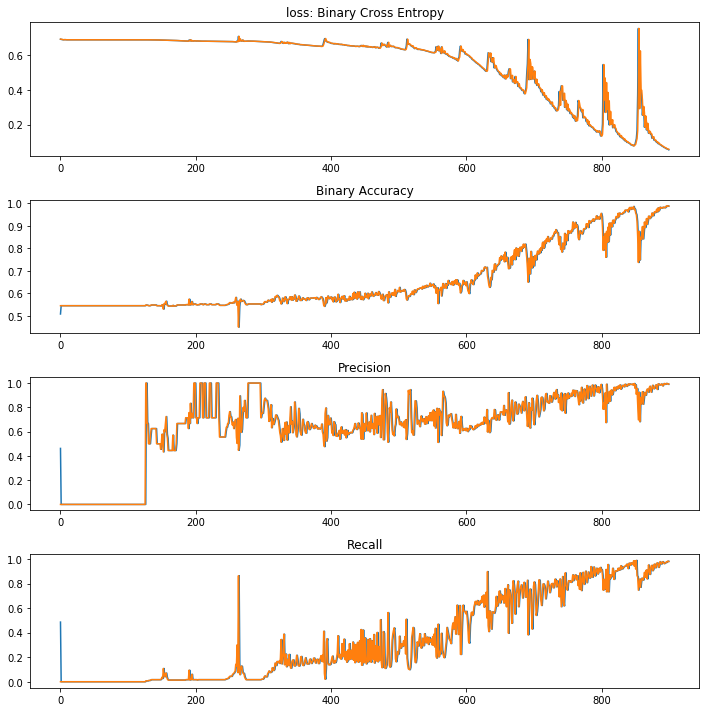

In [47]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), tight_layout=True)
ax[0].plot(history_cls.history['val_loss'])
ax[0].plot(history_cls.history['loss'])
ax[0].set_title('loss: Binary Cross Entropy')
ax[1].plot(history_cls.history['binary_accuracy'])
ax[1].plot(history_cls.history['val_binary_accuracy'])
ax[1].set_title('Binary Accuracy')
ax[2].plot(history_cls.history['precision'])
ax[2].plot(history_cls.history['val_precision'])
ax[2].set_title('Precision')
ax[3].plot(history_cls.history['recall'])
ax[3].plot(history_cls.history['val_recall'])
ax[3].set_title('Recall')
plt.show()

### Adding Text Features

In [6]:
# Hyperparameters
dataset_size = 1000
batch_size = 2

preprocessed_df = pd.read_csv(os.path.join(path_to_data, 'preprocessed.csv'), parse_dates=['timestamp'])

features_to_test = ['log_adj_daily_returns', 'docs']
data_df = preprocessed_df[['timestamp'] + ['_'.join([feature, t]) for t in tickers for feature in features_to_test]]
data_df.head(8)

,timestamp,log_adj_daily_returns_WFC,docs_WFC,log_adj_daily_returns_JPM,docs_JPM,log_adj_daily_returns_BAC,docs_BAC,log_adj_daily_returns_C,docs_C
0,2019-10-22,0.003166,"[""/media/Data/Programs/FinTech/data/documents/...",0.009986,[],0.005786,[],0.003475,[]
1,2019-10-21,0.009758,"[""/media/Data/Programs/FinTech/data/documents/...",0.024498,[],0.021836,[],0.029250,[]
2,2019-10-18,0.007230,"[""/media/Data/Programs/FinTech/data/documents/...",0.001743,[],0.002970,[],0.002009,[]
3,2019-10-17,0.000403,"[""/media/Data/Programs/FinTech/data/documents/...",0.005583,[],0.002979,[],0.001438,[]
4,2019-10-16,-0.010431,[],-0.002337,[],0.014691,"[""/media/Data/Programs/FinTech/data/documents/...",-0.024447,[]
5,2019-10-15,0.016905,"[""/media/Data/Programs/FinTech/data/documents/...",0.029696,"[""/media/Data/Programs/FinTech/data/documents/...",0.020045,[],0.013856,"[""/media/Data/Programs/FinTech/data/documents/..."
6,2019-10-14,0.001219,[],0.002666,[],0.007924,[],0.001995,[]
7,2019-10-11,0.011445,"[""/media/Data/Programs/FinTech/data/documents/...",0.016758,[],0.016039,[],0.021339,[]


In [7]:
df = to_time_series(data_df, data_df.columns, n_trail=5)
df.head()

,timestamp(t-5),log_adj_daily_returns_WFC(t-5),docs_WFC(t-5),log_adj_daily_returns_JPM(t-5),docs_JPM(t-5),log_adj_daily_returns_BAC(t-5),docs_BAC(t-5),log_adj_daily_returns_C(t-5),docs_C(t-5),timestamp(t-4),...,docs_C(t+0),timestamp(t+1),log_adj_daily_returns_WFC(t+1),docs_WFC(t+1),log_adj_daily_returns_JPM(t+1),docs_JPM(t+1),log_adj_daily_returns_BAC(t+1),docs_BAC(t+1),log_adj_daily_returns_C(t+1),docs_C(t+1)
1,2019-10-14,0.001219,[],0.002666,[],0.007924,[],0.001995,[],2019-10-15,...,[],2019-10-22,0.003166,"[""/media/Data/Programs/FinTech/data/documents/...",0.009986,[],0.005786,[],0.003475,[]
2,2019-10-11,0.011445,"[""/media/Data/Programs/FinTech/data/documents/...",0.016758,[],0.016039,[],0.021339,[],2019-10-14,...,[],2019-10-21,0.009758,"[""/media/Data/Programs/FinTech/data/documents/...",0.024498,[],0.021836,[],0.029250,[]
3,2019-10-10,0.010331,[],0.013931,[],0.019880,[],0.017494,[],2019-10-11,...,[],2019-10-18,0.007230,"[""/media/Data/Programs/FinTech/data/documents/...",0.001743,[],0.002970,[],0.002009,[]
4,2019-10-09,0.006877,[],0.007218,[],0.009366,[],0.015393,[],2019-10-10,...,[],2019-10-17,0.000403,"[""/media/Data/Programs/FinTech/data/documents/...",0.005583,[],0.002979,[],0.001438,[]
5,2019-10-08,-0.020491,"[""/media/Data/Programs/FinTech/data/documents/...",-0.022548,[],-0.024313,[],-0.026014,[],2019-10-09,...,"[""/media/Data/Programs/FinTech/data/documents/...",2019-10-16,-0.010431,[],-0.002337,[],0.014691,"[""/media/Data/Programs/FinTech/data/documents/...",-0.024447,[]


In [8]:
feature_names = ['log_adj_daily_returns', 'docs']
col_names_obj = [{fn: [name for name in df.columns if '_'.join([fn, t]) in name] for fn in feature_names}
             for t in tickers]
print(col_names_obj)

[{'log_adj_daily_returns': ['log_adj_daily_returns_WFC(t-5)', 'log_adj_daily_returns_WFC(t-4)', 'log_adj_daily_returns_WFC(t-3)', 'log_adj_daily_returns_WFC(t-2)', 'log_adj_daily_returns_WFC(t-1)', 'log_adj_daily_returns_WFC(t+0)', 'log_adj_daily_returns_WFC(t+1)'], 'docs': ['docs_WFC(t-5)', 'docs_WFC(t-4)', 'docs_WFC(t-3)', 'docs_WFC(t-2)', 'docs_WFC(t-1)', 'docs_WFC(t+0)', 'docs_WFC(t+1)']}, {'log_adj_daily_returns': ['log_adj_daily_returns_JPM(t-5)', 'log_adj_daily_returns_JPM(t-4)', 'log_adj_daily_returns_JPM(t-3)', 'log_adj_daily_returns_JPM(t-2)', 'log_adj_daily_returns_JPM(t-1)', 'log_adj_daily_returns_JPM(t+0)', 'log_adj_daily_returns_JPM(t+1)'], 'docs': ['docs_JPM(t-5)', 'docs_JPM(t-4)', 'docs_JPM(t-3)', 'docs_JPM(t-2)', 'docs_JPM(t-1)', 'docs_JPM(t+0)', 'docs_JPM(t+1)']}, {'log_adj_daily_returns': ['log_adj_daily_returns_BAC(t-5)', 'log_adj_daily_returns_BAC(t-4)', 'log_adj_daily_returns_BAC(t-3)', 'log_adj_daily_returns_BAC(t-2)', 'log_adj_daily_returns_BAC(t-1)', 'log_adj_d

In [9]:
dfs = [{key: df[d[key]] for key in d} for d in col_names_obj]

print('log_adj_daily_returns features')
print()
for i in range(len(tickers)):
    print(dfs[i]['log_adj_daily_returns'].head())
    print()
    print()
    print()
    print()
print()
print('docs features')
print()
for i in range(len(tickers)):
    print(dfs[i]['docs'].head())
    print()
    print()
    print()
    print()

log_adj_daily_returns features

   log_adj_daily_returns_WFC(t-5)  log_adj_daily_returns_WFC(t-4)  \
1                        0.001219                        0.016905   
2                        0.011445                        0.001219   
3                        0.010331                        0.011445   
4                        0.006877                        0.010331   
5                       -0.020491                        0.006877   

   log_adj_daily_returns_WFC(t-3)  log_adj_daily_returns_WFC(t-2)  \
1                       -0.010431                        0.000403   
2                        0.016905                       -0.010431   
3                        0.001219                        0.016905   
4                        0.011445                        0.001219   
5                        0.010331                        0.011445   

   log_adj_daily_returns_WFC(t-1)  log_adj_daily_returns_WFC(t+0)  \
1                        0.007230                        0.009758   


In [10]:
datasets = [{key: d[key].values for key in d} for d in dfs]

In [11]:
dataset = datasets[0] # JPM's dataset
print('dataset\'s features: {}'.format(list(dataset.keys())))
print('Testing if each of test_dataset\'s features have the same length')
dataset_shape = dataset[list(dataset.keys())[0]].shape
assert (dataset[key].shape == dataset_shape for key in dataset.keys())
print('Test passed, test dataset\'s shape: {}'.format(dataset_shape))

dataset's features: ['log_adj_daily_returns', 'docs']
Testing if each of test_dataset's features have the same length
Test passed, test dataset's shape: (5024, 7)


In [12]:
def extract_labels(dataset, label_names):
    labels = {fname: dataset[fname][:, -1] for fname in dataset.keys() if fname in label_names}
    features = {fname: dataset[fname][:, :-1] for fname in dataset.keys()}
    return features, labels

test_dataset_with_labels = extract_labels(dataset, ['log_adj_daily_returns'])
test_features, test_labels = test_dataset_with_labels[0], test_dataset_with_labels[1]
print('Shapes of features of test_dataset with labels included: {}'.format({fn: dataset[fn].shape for fn in dataset}))
print('Shapes of features of test_dataset with labels extracted: {}'.format({fn: test_features[fn].shape for fn in test_features}))
print('Shapes of extracted labels from test_dataset: {}'.format({fn: test_labels[fn].shape for fn in test_labels}))
print('Testing if the extracted labels match the last column (the final timestep) of the test_dataset')
assert np.array_equal(dataset['log_adj_daily_returns'][:, -1], test_labels['log_adj_daily_returns'])
print('Test passed')

Shapes of features of test_dataset with labels included: {'log_adj_daily_returns': (5024, 7), 'docs': (5024, 7)}
Shapes of features of test_dataset with labels extracted: {'log_adj_daily_returns': (5024, 6), 'docs': (5024, 6)}
Shapes of extracted labels from test_dataset: {'log_adj_daily_returns': (5024,)}
Testing if the extracted labels match the last column (the final timestep) of the test_dataset
Test passed


In [13]:
test_sample_docs_feature = dataset['docs'][0] # sample 0's docs features of WFC's dataset
print('sample_docs_feature\'s shape:{}'.format(test_sample_docs_feature.shape))
print('sample_docs_feature')
print(test_sample_docs_feature)

sample_docs_feature's shape:(7,)
sample_docs_feature
['[]'
 '["/media/Data/Programs/FinTech/data/documents/WFC/normalized/encoded/0000072971-19-000383.pickle"]'
 '[]'
 '["/media/Data/Programs/FinTech/data/documents/WFC/normalized/encoded/0000072971-19-000393.pickle"]'
 '["/media/Data/Programs/FinTech/data/documents/WFC/normalized/encoded/0001387131-19-007742.pickle"]'
 '["/media/Data/Programs/FinTech/data/documents/WFC/normalized/encoded/0001387131-19-007757.pickle"]'
 '["/media/Data/Programs/FinTech/data/documents/WFC/normalized/encoded/0001387131-19-007803.pickle"]']


In [14]:
def flatten_docs_feature(docs_feature):
    docs = []
    for timestep in docs_feature:
        docs_list = json.loads(timestep)
        docs.extend(docs_list)
    return docs

flatten_docs_feature(test_sample_docs_feature)

['/media/Data/Programs/FinTech/data/documents/WFC/normalized/encoded/0000072971-19-000383.pickle',
 '/media/Data/Programs/FinTech/data/documents/WFC/normalized/encoded/0000072971-19-000393.pickle',
 '/media/Data/Programs/FinTech/data/documents/WFC/normalized/encoded/0001387131-19-007742.pickle',
 '/media/Data/Programs/FinTech/data/documents/WFC/normalized/encoded/0001387131-19-007757.pickle',
 '/media/Data/Programs/FinTech/data/documents/WFC/normalized/encoded/0001387131-19-007803.pickle']

In [15]:
def decode_docs_feature(docs_feature, seed):
    np.random.seed(seed)
    docs_names = flatten_docs_feature(docs_feature)
    if len(docs_names) != 0:
        windows_doc_name = np.random.choice(docs_names, size=1)[0]
        with open(windows_doc_name, 'rb') as f:
            windows_doc = pickle.load(f)
        window = [windows_doc for _ in range(len(docs_feature))]
    else:
        window = [[] for _ in range(len(docs_feature))]
    return np.stack(window, axis=0)

test_window = decode_docs_feature(test_sample_docs_feature, None)
test_windows_doc = test_window[0]
print('document: {}'.format(test_windows_doc))
print('Testing if each timestep contains the same document that was sampled randomly from the original window')
assert all(np.array_equal(test_window[i], test_windows_doc) for i in range(len(test_window)))
print('Test passed')
print('window\'s shape: {}'.format(test_window.shape))
print('window:')
print(test_window)

document: [  1   1   1 ... 224 225 226]
Testing if each timestep contains the same document that was sampled randomly from the original window
Test passed
window's shape: (7, 1546)
window:
[[  1   1   1 ... 224 225 226]
 [  1   1   1 ... 224 225 226]
 [  1   1   1 ... 224 225 226]
 ...
 [  1   1   1 ... 224 225 226]
 [  1   1   1 ... 224 225 226]
 [  1   1   1 ... 224 225 226]]


In [16]:
# Decoding features and extracting labels
features, labels = extract_labels(dataset, ['log_adj_daily_returns'])
features_decoded = {key: (value if key != 'docs'
                         else list(map(lambda docf: decode_docs_feature(docf, seed), value)))
                   for key, value in features.items()}

In [17]:
# Filtering out samples with no document feature
mask = [(sample.shape[1] != 0) for sample in features_decoded['docs']]

features_filtered = {key: (value[mask, :] if key != 'docs'
                           else [value[i] for i in range(len(mask)) if mask[i]])
                     for key, value in features_decoded.items()}

labels_filtered = {key: value[mask] for key, value in labels.items()}

assert (features_filtered['log_adj_daily_returns'].shape[0] == len(features_filtered['docs']) == labels_filtered['log_adj_daily_returns'].shape[0])

In [18]:
# Sampling Dataset
np.random.seed(seed)
shuffled_indices = np.random.choice(len(features_filtered['docs']), size=dataset_size, replace=False)

features_shuffled = {key: (value[shuffled_indices] if key != 'docs'
                           else [value[i] for i in shuffled_indices])
                     for key, value in features_filtered.items()}

labels_shuffled = {key: value[shuffled_indices] for key, value in labels_filtered.items()}

assert (features_shuffled['log_adj_daily_returns'].shape[0] == len(features_shuffled['docs']) == labels_shuffled['log_adj_daily_returns'].shape[0])

In [19]:
def pad_documents(docs_feature):
    shapes = map(lambda arr: arr.shape, docs_feature)
    longest_doc_len = max(map(lambda shape: shape[-1], shapes))
    pad_doc = lambda arr:  np.pad(arr, ((0, 0), (0, longest_doc_len-arr.shape[-1])), constant_values=0)
    return np.stack(list(map(pad_doc, docs_feature)), axis=0)

In [20]:
# Padding Document Features to the max length of a document
X = {key: (pad_documents(value) if key == 'docs' else value) for key, value in features_shuffled.items()}
y = labels_shuffled['log_adj_daily_returns']
print(X['log_adj_daily_returns'].shape)

(1000, 6)


In [21]:
# Defining functions and classes used to construct model layers

def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                     weights=[current_embedding_matrix], mask_zero=mask_zero,
                                     input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = layers.Embedding(len(vocab) + 1, output_dim=init, 
                                     embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                     activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                     mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer


#### Regression Modeling

In [22]:
# Inspecting Dataset
print(X['log_adj_daily_returns'])
print('Shape of num features: {}'.format(X['log_adj_daily_returns'].shape))
print()
print(y)
print('Shape of labels: {}'.format(y.shape))
print(X['docs'])
print('Shapes of docs features: {}'.format(X['docs'].shape))
print('Testing if each document at each timestep for all samples in docs feature is equal each other')
assert all(np.array_equal(X['docs'][s, i], X['docs'][s, j]) for s in range(dataset_size) for i in range(6) for j in range(6))
print('Test past')

[[ 0.00045633 -0.01149596  0.01969069  0.00474809 -0.00474809 -0.01346608]
 [ 0.0141506   0.01302592  0.00030917  0.0152854  -0.00456189 -0.01442841]
 [ 0.03178836  0.00458189 -0.01178251 -0.01280198  0.00525521  0.03491873]
 ...
 [ 0.01023679 -0.00519479  0.01018749 -0.0103665  -0.00305978 -0.0052389 ]
 [-0.03552021 -0.01716491  0.          0.00061975 -0.01087095 -0.01859904]
 [ 0.00563817  0.00800301  0.00635725  0.          0.00263458 -0.013784  ]]
Shape of num features: (1000, 6)

[-4.58744414e-04  1.44284099e-02  1.61850783e-02  1.03306704e-02
  1.73141657e-03  0.00000000e+00 -2.61111440e-02  2.52574449e-03
 -3.71113578e-03 -5.25012589e-03 -2.59110728e-03  7.78406452e-04
  7.57920325e-03 -8.54676319e-03  7.53360010e-04  7.28151782e-03
  2.93513889e-04 -1.41144445e-03  1.06813910e-02  3.27892122e-04
  2.89563131e-02  3.28871610e-03  3.62221522e-02 -2.42930732e-02
  8.00114402e-03  8.93654242e-03  1.74397441e-03 -2.69755529e-03
 -8.27709547e-03  6.32774261e-03  6.61701761e-03 -1.538

Test past


In [21]:
# Creating a Model and attempting to overfit it
## Defining Model
tf.keras.backend.clear_session()

# Input Layers
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
input_docs = keras.Input(shape=(6, None), name='docs', dtype=tf.int64)
# Slicing Document Input Layer along time axis
timeslice_layers = [layers.Lambda((lambda x: x[:, timestep, :]), output_shape=(None,))(input_docs)
                    for timestep in range(6)]
# Building Word Embedding Layer
word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)
word_embedding_layer_0 = word_embedding(timeslice_layers[0])
word_embedding_layer_1 = word_embedding(timeslice_layers[1])
word_embedding_layer_2 = word_embedding(timeslice_layers[2])
word_embedding_layer_3 = word_embedding(timeslice_layers[3])
word_embedding_layer_4 = word_embedding(timeslice_layers[4]) # adding the 5th timeslice does weird stuf, the model trains with all the previous 4 timeslices
word_embedding_layer_5 = word_embedding(timeslice_layers[5])
#word_embedding_layers = [word_embedding(timeslice_layers[timestep]) for timestep in range(6)]
# Building Document Embedding Layer
document_embedding = layers.LSTM(100)
document_embedding_layer_0 = document_embedding(word_embedding_layer_0)
document_embedding_layer_1 = document_embedding(word_embedding_layer_1)
document_embedding_layer_2 = document_embedding(word_embedding_layer_2)
document_embedding_layer_3 = document_embedding(word_embedding_layer_3)
document_embedding_layer_4 = document_embedding(word_embedding_layer_4) # adding the 5th timeslice does weird stuf, the model trains with all the previous 4 timeslices
document_embedding_layer_5 = document_embedding(word_embedding_layer_5)
#document_embedding_layers = [document_embedding(word_embedding_layers[timestep]) for timestep in range(6)]
# Creating input to time series layer
num_features_layer = layers.Lambda((lambda x: keras.backend.expand_dims(x, axis=-1)),
                                   output_shape=(6, 1))(input_log_returns)
doc_features_layer = layers.Lambda((lambda x: keras.backend.stack(x, axis=1)),
                                   output_shape=(6, 100))([document_embedding_layer_0,
                                                           document_embedding_layer_1,
                                                           document_embedding_layer_2,
                                                           document_embedding_layer_3,
                                                           document_embedding_layer_4,
                                                           document_embedding_layer_5])
ts_input = layers.Concatenate()([doc_features_layer, num_features_layer])
# Time series component
ts_layer_1 = layers.LSTM(32, return_sequences=False)(ts_input)
#ts_layer_2 = layers.LSTM(500, return_sequences=True)(ts_layer_1)
#ts_layer_3 = layers.LSTM(300, return_sequences=True)(ts_layer_2)
#ts_layer_4 = layers.LSTM(160, return_sequences=True)(ts_layer_3)
#ts_layer_5 = layers.LSTM(50, return_sequences=False)(ts_layer_4)
output = layers.Dense(1)(ts_layer_1)

model = keras.Model([input_log_returns, input_docs], output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=None)
print(model.summary())
#keras.utils.plot_model(model, 'test.png', show_shapes=True)

print(batch_size)
history = model.fit(x=X, y=y, batch_size=batch_size, epochs=10, validation_data =(X, y))

# the overall state of the hardware is effected too, when I get a single crash from changing 0 --> 4 
# if I change 4 ---> 0 then i get the same crash, if I reset tensorflow then it works 

Model: "test_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
docs (InputLayer)               [(None, 6, None)]    0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           docs[0][0]                       
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None)         0           docs[0][0]                       
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None)         0           docs[0][0]                       
_________________________________________________________________________________________

SystemError: <built-in function len> returned a result with an error set

##### Investigating crash of regression model

It appears from the above cell that the model is crashing somewhere in its backpropagation step. From inspection of the source code it seems like there are some issues with the shapes of gradients when slicing the docs input.

In [25]:
# Creating a Model and attempting to overfit it
## Defining Model
tf.keras.backend.clear_session()

# Input Layers
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
input_docs = keras.Input(shape=(6, None), name='docs', dtype=tf.int64)

# Slicing Document Input Layer along time axis
timeslice_layers = [layers.Lambda((lambda x: x[:, timestep, :]), output_shape=(None,))(input_docs)
                    for timestep in range(6)]

# Building Word Embedding Layer
word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)
word_embedding_layer_0 = word_embedding(timeslice_layers[0])
word_embedding_layer_1 = word_embedding(timeslice_layers[1])
word_embedding_layer_2 = word_embedding(timeslice_layers[2])
word_embedding_layer_3 = word_embedding(timeslice_layers[3])
word_embedding_layer_4 = word_embedding(timeslice_layers[4]) # adding the 5th timeslice does weird stuf, the model trains with all the previous 4 timeslices
word_embedding_layer_5 = word_embedding(timeslice_layers[5])

# Building Document Embedding Layer
document_embedding = layers.LSTM(100)
document_embedding_layer_0 = document_embedding(word_embedding_layer_0)
document_embedding_layer_1 = document_embedding(word_embedding_layer_1)
document_embedding_layer_2 = document_embedding(word_embedding_layer_2)
document_embedding_layer_3 = document_embedding(word_embedding_layer_3)
document_embedding_layer_4 = document_embedding(word_embedding_layer_4) # adding the 5th timeslice does weird stuf, the model trains with all the previous 4 timeslices
document_embedding_layer_5 = document_embedding(word_embedding_layer_5)

# Creating input to time series layer
num_features_layer = layers.Lambda((lambda x: keras.backend.expand_dims(x, axis=-1)),
                                   output_shape=(6, 1))(input_log_returns)
doc_features_layer = layers.Lambda((lambda x: keras.backend.stack(x, axis=1)),
                                   output_shape=(6, 100))([document_embedding_layer_0,
                                                           document_embedding_layer_0,
                                                           document_embedding_layer_0,
                                                           document_embedding_layer_0,
                                                           document_embedding_layer_0,
                                                           document_embedding_layer_0])
ts_input = layers.Concatenate()([doc_features_layer, num_features_layer])

# Time series component
ts_layer_1 = layers.LSTM(32, return_sequences=False)(ts_input)
output = layers.Dense(1)(ts_layer_1)

model = keras.Model([input_log_returns, input_docs], output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=None)
print(model.summary())
#keras.utils.plot_model(model, 'test.png', show_shapes=True)

print(batch_size)
history = model.fit(x=X, y=y, batch_size=batch_size, epochs=10, validation_data =(X, y))

# the overall state of the hardware is effected too, when I get a single crash from changing 0 --> 4 
# if I change 4 ---> 0 then i get the same crash, if I reset tensorflow then it works

Model: "test_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
docs (InputLayer)               [(None, 6, None)]    0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           docs[0][0]                       
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    2747100     lambda[0][0]                     
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100)          160400      embedding[0][0]                  
_________________________________________________________________________________________

From the above cell it appears that if we take only one slice layer and copy it multiple times then apply our stack layer, the model seems to backpropagate fine. This implies maybe there might be something up with the stack layer: doc_features_layer.

In [26]:
# Creating a Model and attempting to overfit it
## Defining Model
tf.keras.backend.clear_session()

# Input Layers
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
input_docs = keras.Input(shape=(6, None), name='docs', dtype=tf.int64)

# Slicing Document Input Layer along time axis
timeslice_layers = [layers.Lambda((lambda x: x[:, timestep, :]), output_shape=(None,))(input_docs)
                    for timestep in range(6)]

# Building Word Embedding Layer
word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False, input_length=1466)
word_embedding_layer_0 = word_embedding(timeslice_layers[0])
word_embedding_layer_1 = word_embedding(timeslice_layers[1])
word_embedding_layer_2 = word_embedding(timeslice_layers[2])
word_embedding_layer_3 = word_embedding(timeslice_layers[3])
word_embedding_layer_4 = word_embedding(timeslice_layers[4]) # adding the 5th timeslice does weird stuf, the model trains with all the previous 4 timeslices
word_embedding_layer_5 = word_embedding(timeslice_layers[5])

# Building Document Embedding Layer
document_embedding = layers.LSTM(100)
document_embedding_layer_0 = document_embedding(word_embedding_layer_0)
document_embedding_layer_1 = document_embedding(word_embedding_layer_1)
document_embedding_layer_2 = document_embedding(word_embedding_layer_2)
document_embedding_layer_3 = document_embedding(word_embedding_layer_3)
document_embedding_layer_4 = document_embedding(word_embedding_layer_4) # adding the 5th timeslice does weird stuf, the model trains with all the previous 4 timeslices
document_embedding_layer_5 = document_embedding(word_embedding_layer_5)

# Creating input to time series layer
num_features_layer = layers.Lambda((lambda x: keras.backend.expand_dims(x, axis=-1)),
                                   output_shape=(6, 1))(input_log_returns)
doc_features_layer = layers.Lambda((lambda x: keras.backend.stack(x, axis=1)),
                                   output_shape=(6, 100))([document_embedding_layer_0,
                                                           document_embedding_layer_1,
                                                           document_embedding_layer_2,
                                                           document_embedding_layer_3,
                                                           document_embedding_layer_0,
                                                           document_embedding_layer_0])
ts_input = layers.Concatenate()([doc_features_layer, num_features_layer])
# Time series component
ts_layer_1 = layers.LSTM(32, return_sequences=False)(ts_input)
output = layers.Dense(1)(ts_layer_1)

model = keras.Model([input_log_returns, input_docs], output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=None)
print(model.summary())
#keras.utils.plot_model(model, 'test.png', show_shapes=True)

print(batch_size)
history = model.fit(x=X, y=y, batch_size=batch_size, epochs=10, validation_data =(X, y))

# the overall state of the hardware is effected too, when I get a single crash from changing 0 --> 4 
# if I change 4 ---> 0 then i get the same crash, if I reset tensorflow then it works 

Model: "test_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
docs (InputLayer)               [(None, 6, None)]    0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           docs[0][0]                       
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None)         0           docs[0][0]                       
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None)         0           docs[0][0]                       
_________________________________________________________________________________________

In [27]:
# Creating a Model and attempting to overfit it
## Defining Model
tf.keras.backend.clear_session()

# Input Layers
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
input_docs = keras.Input(shape=(6, None), name='docs', dtype=tf.int64)
# Slicing Document Input Layer along time axis
timeslice_layers = [layers.Lambda((lambda x: x[:, timestep, :]), output_shape=(None,))(input_docs)
                    for timestep in range(6)]
# Building Word Embedding Layer
word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)
word_embedding_layer_0 = word_embedding(timeslice_layers[0])
word_embedding_layer_1 = word_embedding(timeslice_layers[1])
word_embedding_layer_2 = word_embedding(timeslice_layers[2])
word_embedding_layer_3 = word_embedding(timeslice_layers[3])
word_embedding_layer_4 = word_embedding(timeslice_layers[4]) # adding the 5th timeslice does weird stuf, the model trains with all the previous 4 timeslices
word_embedding_layer_5 = word_embedding(timeslice_layers[5])
#word_embedding_layers = [word_embedding(timeslice_layers[timestep]) for timestep in range(6)]
# Building Document Embedding Layer
document_embedding = layers.LSTM(100)
document_embedding_layer_0 = document_embedding(word_embedding_layer_0)
document_embedding_layer_1 = document_embedding(word_embedding_layer_1)
document_embedding_layer_2 = document_embedding(word_embedding_layer_2)
document_embedding_layer_3 = document_embedding(word_embedding_layer_3)
document_embedding_layer_4 = document_embedding(word_embedding_layer_4) # adding the 5th timeslice does weird stuf, the model trains with all the previous 4 timeslices
document_embedding_layer_5 = document_embedding(word_embedding_layer_5)
#document_embedding_layers = [document_embedding(word_embedding_layers[timestep]) for timestep in range(6)]
# Creating input to time series layer
num_features_layer = layers.Lambda((lambda x: keras.backend.expand_dims(x, axis=-1)),
                                   output_shape=(6, 1))(input_log_returns)
doc_features_layer = layers.Lambda((lambda x: keras.backend.stack(x, axis=1)),
                                   output_shape=(6, 100))([document_embedding_layer_0,
                                                           document_embedding_layer_1,
                                                           document_embedding_layer_2,
                                                           document_embedding_layer_3,
                                                           document_embedding_layer_4,
                                                           document_embedding_layer_0])
ts_input = layers.Concatenate()([doc_features_layer, num_features_layer])
# Time series component
ts_layer_1 = layers.LSTM(32, return_sequences=False)(ts_input)
#ts_layer_2 = layers.LSTM(500, return_sequences=True)(ts_layer_1)
#ts_layer_3 = layers.LSTM(300, return_sequences=True)(ts_layer_2)
#ts_layer_4 = layers.LSTM(160, return_sequences=True)(ts_layer_3)
#ts_layer_5 = layers.LSTM(50, return_sequences=False)(ts_layer_4)
output = layers.Dense(1)(ts_layer_1)

model = keras.Model([input_log_returns, input_docs], output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=None)
print(model.summary())
#keras.utils.plot_model(model, 'test.png', show_shapes=True)

print(batch_size)
history = model.fit(x=X, y=y, batch_size=batch_size, epochs=10, validation_data =(X, y))

# the overall state of the hardware is effected too, when I get a single crash from changing 0 --> 4 
# if I change 4 ---> 0 then i get the same crash, if I reset tensorflow then it works 

Model: "test_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
docs (InputLayer)               [(None, 6, None)]    0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           docs[0][0]                       
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None)         0           docs[0][0]                       
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None)         0           docs[0][0]                       
_________________________________________________________________________________________

SystemError: PyEval_EvalFrameEx returned a result with an error set

From the above to cells we find that the backpropagation crashes when we try to apply our stack layer to a list of more than 3 unique slice layers (as opposed to a list of contains less than 3 unique slice layers where the empty slots are filled with copies of already included slice layers). This further supports that maybe the stacking layer is the cause.

In [28]:
# Creating a Model and attempting to overfit it
## Defining Model
tf.keras.backend.clear_session()

# Input Layers
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
input_docs = keras.Input(shape=(6, None), name='docs', dtype=tf.int64)

# Slicing Document Input Layer along time axis
timeslice_layers = [layers.Lambda((lambda x: x[:, timestep, :]), output_shape=(None,))(input_docs)
                    for timestep in range(6)]

timeslice_layer_0 = timeslice_layers[0]
timeslice_layer_1 = timeslice_layers[1]
timeslice_layer_2 = timeslice_layers[2]
timeslice_layer_3 = timeslice_layers[3]
timeslice_layer_4 = timeslice_layers[4]
timeslice_layer_5 = timeslice_layers[5]

# Rebuilding Original Input from Time Slices
rebuilt_input_layer = layers.Lambda((lambda x: keras.backend.stack(x, axis=1)), 
                                    output_shape=(6, None))([timeslice_layer_0,
                                                            timeslice_layer_1,
                                                            timeslice_layer_2,
                                                            timeslice_layer_3,
                                                            timeslice_layer_4,
                                                            timeslice_layer_5])
                                    
doc_layer_0 = layers.Lambda((lambda x: x[:, 0, :]), output_shape=(None,))(rebuilt_input_layer)
doc_layer_1 = layers.Lambda((lambda x: x[:, 1, :]), output_shape=(None,))(rebuilt_input_layer)
doc_layer_2 = layers.Lambda((lambda x: x[:, 2, :]), output_shape=(None,))(rebuilt_input_layer)
doc_layer_3 = layers.Lambda((lambda x: x[:, 3, :]), output_shape=(None,))(rebuilt_input_layer)
doc_layer_4 = layers.Lambda((lambda x: x[:, 4, :]), output_shape=(None,))(rebuilt_input_layer)
doc_layer_5 = layers.Lambda((lambda x: x[:, 5, :]), output_shape=(None,))(rebuilt_input_layer)

# Building Word Embedding Layer
word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)
word_embedding_layer_0 = word_embedding(doc_layer_0)
word_embedding_layer_1 = word_embedding(doc_layer_1)
word_embedding_layer_2 = word_embedding(doc_layer_2)
word_embedding_layer_3 = word_embedding(doc_layer_3)
word_embedding_layer_4 = word_embedding(doc_layer_4) # adding the 5th timeslice does weird stuf, the model trains with all the previous 4 timeslices
word_embedding_layer_5 = word_embedding(doc_layer_5)

# Building Document Embedding Layer
document_embedding = layers.LSTM(100)
document_embedding_layer_0 = document_embedding(word_embedding_layer_0)
document_embedding_layer_1 = document_embedding(word_embedding_layer_1)
document_embedding_layer_2 = document_embedding(word_embedding_layer_2)
document_embedding_layer_3 = document_embedding(word_embedding_layer_3)
document_embedding_layer_4 = document_embedding(word_embedding_layer_4) # adding the 5th timeslice does weird stuf, the model trains with all the previous 4 timeslices
document_embedding_layer_5 = document_embedding(word_embedding_layer_5)

# Creating input to time series layer
num_features_layer = layers.Lambda((lambda x: keras.backend.expand_dims(x, axis=-1)),
                                   output_shape=(6, 1))(input_log_returns)

doc_features_layer = layers.Lambda((lambda x: keras.backend.stack(x, axis=1)),
                                   output_shape=(6, 100))([document_embedding_layer_0,
                                                           document_embedding_layer_0,
                                                           document_embedding_layer_0,
                                                           document_embedding_layer_0,
                                                           document_embedding_layer_0,
                                                           document_embedding_layer_0])

ts_input = layers.Concatenate()([doc_features_layer, num_features_layer])

# Time series component
ts_layer_1 = layers.LSTM(32, return_sequences=False)(ts_input)
output = layers.Dense(1)(ts_layer_1)

model = keras.Model([input_log_returns, input_docs], output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=None)
print(model.summary())
print(batch_size)
#keras.utils.plot_model(model, 'test.png', show_shapes=True)


history = model.fit(x=X, y=y, batch_size=batch_size, epochs=10, validation_data =(X, y))

Model: "test_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
docs (InputLayer)               [(None, 6, None)]    0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           docs[0][0]                       
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None)         0           docs[0][0]                       
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None)         0           docs[0][0]                       
_________________________________________________________________________________________

Here we try to test our stacking layer, by slicing the input_docs layer, and immediately stacking all unique slices of it, then applying a sequence of layers we know backpropagation doesn't break on. The results show that our stacking layer isn't at fault. This implies that there is something up with the layers that we apply to each slice (word_embedding, and doc_embedding)

In [29]:
# Creating a Model and attempting to overfit it
## Defining Model
tf.keras.backend.clear_session()

# Input Layers
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
input_docs = keras.Input(shape=(6, None), name='docs', dtype=tf.int64)

# Slicing Document Input Layer along time axis
timeslice_layers = [layers.Lambda((lambda x: x[:, timestep, :]), output_shape=(None,))(input_docs)
                    for timestep in range(6)]

# Building Word Embedding Layer
word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)
word_embedding_layer_0 = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(timeslice_layers[0])
word_embedding_layer_1 = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(timeslice_layers[1])
word_embedding_layer_2 = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(timeslice_layers[2])
word_embedding_layer_3 = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(timeslice_layers[3])
word_embedding_layer_4 = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(timeslice_layers[4]) # adding the 5th timeslice does weird stuf, the model trains with all the previous 4 timeslices
word_embedding_layer_5 = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(timeslice_layers[5])

# Building Document Embedding Layer
document_embedding_layer_0 = layers.LSTM(100)(word_embedding_layer_0)
document_embedding_layer_1 = layers.LSTM(100)(word_embedding_layer_1)
document_embedding_layer_2 = layers.LSTM(100)(word_embedding_layer_2)
document_embedding_layer_3 = layers.LSTM(100)(word_embedding_layer_3)
document_embedding_layer_4 = layers.LSTM(100)(word_embedding_layer_4) # adding the 5th timeslice does weird stuf, the model trains with all the previous 4 timeslices
document_embedding_layer_5 = layers.LSTM(100)(word_embedding_layer_5)

# Creating input to time series layer
num_features_layer = layers.Lambda((lambda x: keras.backend.expand_dims(x, axis=-1)),
                                   output_shape=(6, 1))(input_log_returns)
doc_features_layer = layers.Lambda((lambda x: keras.backend.stack(x, axis=1)),
                                   output_shape=(6, 100))([document_embedding_layer_0,
                                                           document_embedding_layer_1,
                                                           document_embedding_layer_2,
                                                           document_embedding_layer_3,
                                                           document_embedding_layer_4,
                                                           document_embedding_layer_5])
ts_input = layers.Concatenate()([doc_features_layer, num_features_layer])

# Time series component
ts_layer_1 = layers.LSTM(32, return_sequences=False)(ts_input)
output = layers.Dense(1)(ts_layer_1)

model = keras.Model([input_log_returns, input_docs], output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=None)
print(model.summary())
#keras.utils.plot_model(model, 'test.png', show_shapes=True)

print(batch_size)
history = model.fit(x=X, y=y, batch_size=batch_size, epochs=10, validation_data =(X, y))

Model: "test_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
docs (InputLayer)               [(None, 6, None)]    0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           docs[0][0]                       
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None)         0           docs[0][0]                       
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None)         0           docs[0][0]                       
_________________________________________________________________________________________

Here we created seperate word_embedding_layers and document_embedding_layers for each slice layer ie the document and word embedding layers are seperated for each slice, and do not share weights between each slice. Backpropagation seems to work which implies that the error is raised because of the logic of sharing weights between slice layers. 

#### Rebuilding Regression Model

In [ ]:
# Creating a Model and attempting to overfit it
## Defining Model
tf.keras.backend.clear_session()

# Input Layers
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
input_docs = keras.Input(shape=(6, None), name='docs')

# Defining document_embedder model
def document_embedder():
    input_doc = keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = layers.LSTM(100)(word_embedding)
    model = keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

# Creating input to time series layer
num_features = layers.Lambda((lambda x: keras.backend.expand_dims(x, axis=-1)), output_shape=(6, 1))(input_log_returns)
document_embeddings = layers.TimeDistributed(document_embedder())(input_docs)

ts_input = layers.Concatenate()([document_embeddings, num_features])

# Time series component
ts_layer_1 = layers.LSTM(32, return_sequences=False)(ts_input)
#ts_layer_2 = layers.LSTM(500, return_sequences=True)(ts_layer_1)
#ts_layer_3 = layers.LSTM(300, return_sequences=True)(ts_layer_2)
#ts_layer_4 = layers.LSTM(160, return_sequences=True)(ts_layer_3)
#ts_layer_5 = layers.LSTM(50, return_sequences=False)(ts_layer_4)
output = layers.Dense(1)(ts_layer_1)

model = keras.Model([input_log_returns, input_docs], output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=None)
print(model.summary())
print(batch_size)
#keras.utils.plot_model(model, 'test.png', show_shapes=True)


history = model.fit(x=X, y=y, batch_size=batch_size, epochs=90, validation_data =(X, y))

Model: "test_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
docs (InputLayer)               [(None, 6, None)]    0                                            
__________________________________________________________________________________________________
log_adj_daily_returns (InputLay [(None, 6)]          0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 6, 100)       2907500     docs[0][0]                       
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 6, 1)         0           log_adj_daily_returns[0][0]      
_________________________________________________________________________________________

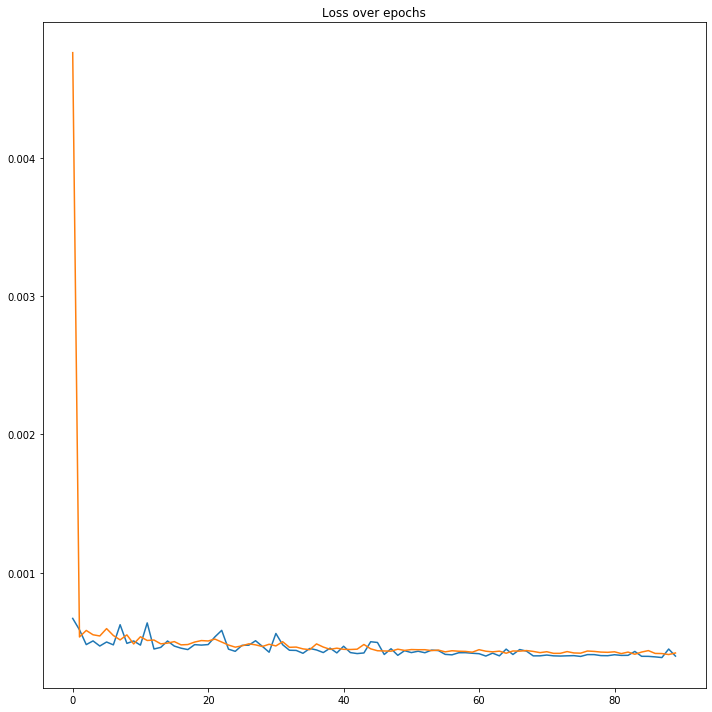

In [23]:
fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
ax.plot(history.history['val_loss'])
ax.plot(history.history['loss'])
ax.set_title('Loss over epochs')
plt.show()

#### Classification Modeling

In [39]:
# Mapping labels to categorical labels
def to_categorical(el):
    if el > 0:
        c = 1
    else:
        c = 0
    return c

y_cls = np.array(list(map(to_categorical, y)))
print('Probability of sampling a 1: {}'.format(y_cls.sum()/len(y_cls)))
print('Probability of sampling a 0: {}'.format((len(y_cls) - y_cls.sum())/len(y_cls)))

Probability of sampling a 1: 0.5
Probability of sampling a 0: 0.5


In [40]:
# Creating a Model and attempting to overfit it
## Defining Model
tf.keras.backend.clear_session()

# Input Layers
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
input_docs = keras.Input(shape=(6, None), name='docs')

# Defining document_embedder model
def document_embedder():
    input_doc = keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = layers.LSTM(100)(word_embedding)
    model = keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

# Creating input to time series layer
num_features = layers.Lambda((lambda x: keras.backend.expand_dims(x, axis=-1)), output_shape=(6, 1))(input_log_returns)
document_embeddings = layers.TimeDistributed(document_embedder())(input_docs)

ts_input = layers.Concatenate()([document_embeddings, num_features])

# Time series component
ts_layer_1 = layers.LSTM(32, return_sequences=False)(ts_input)
#ts_layer_2 = layers.LSTM(500, return_sequences=True)(ts_layer_1)
#ts_layer_3 = layers.LSTM(300, return_sequences=True)(ts_layer_2)
#ts_layer_4 = layers.LSTM(160, return_sequences=True)(ts_layer_3)
#ts_layer_5 = layers.LSTM(50, return_sequences=False)(ts_layer_4)
output = layers.Dense(1, activation='sigmoid')(ts_layer_1)

model = keras.Model([input_log_returns, input_docs], output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()])

print(model.summary())
print(batch_size)
#keras.utils.plot_model(model, 'test.png', show_shapes=True)


history_cls = model.fit(x=X, y=y_cls, batch_size=batch_size, epochs=900, validation_data =(X, y_cls))

Model: "test_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
docs (InputLayer)               [(None, 6, None)]    0                                            
__________________________________________________________________________________________________
log_adj_daily_returns (InputLay [(None, 6)]          0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 6, 100)       2907500     docs[0][0]                       
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 6, 1)         0           log_adj_daily_returns[0][0]      
_________________________________________________________________________________________

Epoch 27/900
10/10 [==============================] - 0s 34ms/sample - loss: 0.0038 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0037 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 28/900
10/10 [==============================] - 0s 33ms/sample - loss: 0.0036 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0034 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 29/900
10/10 [==============================] - 0s 33ms/sample - loss: 0.0034 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0032 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 30/900
10/10 [==============================] - 0s 33ms/sample - loss: 0.0032 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0031 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 31/900
10/10 [================

Epoch 61/900
10/10 [==============================] - 0s 32ms/sample - loss: 0.0010 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 9.9966e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 62/900
10/10 [==============================] - 0s 33ms/sample - loss: 9.9281e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 9.7411e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 63/900
10/10 [==============================] - 0s 33ms/sample - loss: 9.6835e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 9.4956e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 64/900
10/10 [==============================] - 0s 34ms/sample - loss: 9.4426e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 9.2621e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 65

Epoch 94/900
10/10 [==============================] - 0s 32ms/sample - loss: 5.3498e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.2936e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 95/900
10/10 [==============================] - 0s 34ms/sample - loss: 5.2740e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.2215e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 96/900
10/10 [==============================] - 0s 33ms/sample - loss: 5.2052e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.1507e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 97/900
10/10 [==============================] - 0s 34ms/sample - loss: 5.1344e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.0827e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoc

Epoch 127/900
10/10 [==============================] - 0s 32ms/sample - loss: 3.6880e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.6620e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 128/900
10/10 [==============================] - 0s 36ms/sample - loss: 3.6530e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.6286e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 129/900
10/10 [==============================] - 0s 34ms/sample - loss: 3.6206e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.5956e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 130/900
10/10 [==============================] - 0s 33ms/sample - loss: 3.5868e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.5634e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 160/900
10/10 [==============================] - 0s 33ms/sample - loss: 2.8051e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.7899e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 161/900
10/10 [==============================] - 0s 32ms/sample - loss: 2.7849e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.7692e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 162/900
10/10 [==============================] - 0s 32ms/sample - loss: 2.7639e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.7489e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 163/900
10/10 [==============================] - 0s 33ms/sample - loss: 2.7438e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.7288e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 193/900
10/10 [==============================] - 0s 33ms/sample - loss: 2.2330e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.2221e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 194/900
10/10 [==============================] - 0s 33ms/sample - loss: 2.2185e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.2082e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 195/900
10/10 [==============================] - 0s 36ms/sample - loss: 2.2041e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.1944e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 196/900
10/10 [==============================] - 0s 33ms/sample - loss: 2.1908e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.1805e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 226/900
10/10 [==============================] - 0s 35ms/sample - loss: 1.8341e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.8268e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 227/900
10/10 [==============================] - 0s 33ms/sample - loss: 1.8236e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.8165e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 228/900
10/10 [==============================] - 0s 33ms/sample - loss: 1.8136e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.8062e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 229/900
10/10 [==============================] - 0s 33ms/sample - loss: 1.8035e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7960e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 259/900
10/10 [==============================] - 0s 33ms/sample - loss: 1.5453e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.5397e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 260/900
10/10 [==============================] - 0s 34ms/sample - loss: 1.5379e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.5325e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 261/900
10/10 [==============================] - 0s 36ms/sample - loss: 1.5306e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.5254e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 262/900
10/10 [==============================] - 0s 33ms/sample - loss: 1.5236e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.5184e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 292/900
10/10 [==============================] - 0s 34ms/sample - loss: 1.3367e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.3325e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 293/900
10/10 [==============================] - 0s 34ms/sample - loss: 1.3311e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.3271e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 294/900
10/10 [==============================] - 0s 34ms/sample - loss: 1.3256e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.3216e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 295/900
10/10 [==============================] - 0s 34ms/sample - loss: 1.3202e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.3162e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 325/900
10/10 [==============================] - 0s 34ms/sample - loss: 1.1733e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1699e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 326/900
10/10 [==============================] - 0s 34ms/sample - loss: 1.1687e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1655e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 327/900
10/10 [==============================] - 0s 33ms/sample - loss: 1.1645e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1612e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 328/900
10/10 [==============================] - 0s 32ms/sample - loss: 1.1600e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1569e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 358/900
10/10 [==============================] - 0s 34ms/sample - loss: 1.0406e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0380e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 359/900
10/10 [==============================] - 0s 34ms/sample - loss: 1.0371e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0344e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 360/900
10/10 [==============================] - 0s 34ms/sample - loss: 1.0334e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0308e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 361/900
10/10 [==============================] - 0s 34ms/sample - loss: 1.0298e-04 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0272e-04 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 391/900
10/10 [==============================] - 0s 34ms/sample - loss: 9.2984e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 9.2760e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 392/900
10/10 [==============================] - 0s 35ms/sample - loss: 9.2677e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 9.2456e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 393/900
10/10 [==============================] - 0s 34ms/sample - loss: 9.2372e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 9.2152e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 394/900
10/10 [==============================] - 0s 33ms/sample - loss: 9.2073e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 9.1848e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 424/900
10/10 [==============================] - 0s 35ms/sample - loss: 8.3593e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 8.3402e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 425/900
10/10 [==============================] - 0s 34ms/sample - loss: 8.3332e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 8.3140e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 426/900
10/10 [==============================] - 0s 34ms/sample - loss: 8.3066e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 8.2879e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 427/900
10/10 [==============================] - 0s 34ms/sample - loss: 8.2807e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 8.2618e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 457/900
10/10 [==============================] - 0s 34ms/sample - loss: 7.5527e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 7.5362e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 458/900
10/10 [==============================] - 0s 34ms/sample - loss: 7.5302e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 7.5136e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 459/900
10/10 [==============================] - 0s 34ms/sample - loss: 7.5076e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 7.4911e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 460/900
10/10 [==============================] - 0s 32ms/sample - loss: 7.4852e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 7.4688e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 490/900
10/10 [==============================] - 0s 34ms/sample - loss: 6.8563e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 6.8419e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 491/900
10/10 [==============================] - 0s 33ms/sample - loss: 6.8369e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 6.8223e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 492/900
10/10 [==============================] - 0s 32ms/sample - loss: 6.8169e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 6.8028e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 493/900
10/10 [==============================] - 0s 32ms/sample - loss: 6.7978e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 6.7834e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 523/900
10/10 [==============================] - 0s 35ms/sample - loss: 6.2480e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 6.2354e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 524/900
10/10 [==============================] - 0s 34ms/sample - loss: 6.2310e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 6.2184e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 525/900
10/10 [==============================] - 0s 34ms/sample - loss: 6.2139e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 6.2014e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 526/900
10/10 [==============================] - 0s 33ms/sample - loss: 6.1968e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 6.1845e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 556/900
10/10 [==============================] - 0s 33ms/sample - loss: 5.7140e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.7029e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 557/900
10/10 [==============================] - 0s 33ms/sample - loss: 5.6989e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.6877e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 558/900
10/10 [==============================] - 0s 33ms/sample - loss: 5.6838e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.6726e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 559/900
10/10 [==============================] - 0s 34ms/sample - loss: 5.6685e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.6575e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 589/900
10/10 [==============================] - 0s 34ms/sample - loss: 5.2420e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.2321e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 590/900
10/10 [==============================] - 0s 32ms/sample - loss: 5.2287e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.2187e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 591/900
10/10 [==============================] - 0s 34ms/sample - loss: 5.2151e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.2054e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 592/900
10/10 [==============================] - 0s 32ms/sample - loss: 5.2018e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.1920e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 622/900
10/10 [==============================] - 0s 34ms/sample - loss: 4.8209e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.8122e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 623/900
10/10 [==============================] - 0s 33ms/sample - loss: 4.8090e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.8002e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 624/900
10/10 [==============================] - 0s 34ms/sample - loss: 4.7971e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.7882e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 625/900
10/10 [==============================] - 0s 34ms/sample - loss: 4.7850e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.7762e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 655/900
10/10 [==============================] - 0s 33ms/sample - loss: 4.4448e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.4369e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 656/900
10/10 [==============================] - 0s 34ms/sample - loss: 4.4341e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.4261e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 657/900
10/10 [==============================] - 0s 34ms/sample - loss: 4.4233e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.4154e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 658/900
10/10 [==============================] - 0s 35ms/sample - loss: 4.4125e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.4047e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 688/900
10/10 [==============================] - 0s 33ms/sample - loss: 4.1072e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.1000e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 689/900
10/10 [==============================] - 0s 34ms/sample - loss: 4.0975e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.0903e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 690/900
10/10 [==============================] - 0s 33ms/sample - loss: 4.0878e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.0808e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 691/900
10/10 [==============================] - 0s 34ms/sample - loss: 4.0782e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.0712e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 721/900
10/10 [==============================] - 0s 34ms/sample - loss: 3.8025e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.7961e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 722/900
10/10 [==============================] - 0s 34ms/sample - loss: 3.7939e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.7873e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 723/900
10/10 [==============================] - 0s 34ms/sample - loss: 3.7850e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.7787e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 724/900
10/10 [==============================] - 0s 33ms/sample - loss: 3.7764e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.7700e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 754/900
10/10 [==============================] - 0s 35ms/sample - loss: 3.5273e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.5214e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 755/900
10/10 [==============================] - 0s 33ms/sample - loss: 3.5193e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.5135e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 756/900
10/10 [==============================] - 0s 34ms/sample - loss: 3.5114e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.5056e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 757/900
10/10 [==============================] - 0s 33ms/sample - loss: 3.5035e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.4977e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 787/900
10/10 [==============================] - 0s 34ms/sample - loss: 3.2773e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.2719e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 788/900
10/10 [==============================] - 0s 32ms/sample - loss: 3.2700e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.2647e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 789/900
10/10 [==============================] - 0s 34ms/sample - loss: 3.2628e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.2576e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 790/900
10/10 [==============================] - 0s 35ms/sample - loss: 3.2557e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.2505e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 820/900
10/10 [==============================] - 0s 34ms/sample - loss: 3.0497e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.0448e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 821/900
10/10 [==============================] - 0s 33ms/sample - loss: 3.0432e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.0382e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 822/900
10/10 [==============================] - 0s 34ms/sample - loss: 3.0365e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.0317e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 823/900
10/10 [==============================] - 0s 34ms/sample - loss: 3.0300e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.0252e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 853/900
10/10 [==============================] - 0s 34ms/sample - loss: 2.8418e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.8374e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 854/900
10/10 [==============================] - 0s 32ms/sample - loss: 2.8358e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.8314e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 855/900
10/10 [==============================] - 0s 34ms/sample - loss: 2.8298e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.8254e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 856/900
10/10 [==============================] - 0s 34ms/sample - loss: 2.8238e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.8195e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


Epoch 886/900
10/10 [==============================] - 0s 34ms/sample - loss: 2.6517e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.6477e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 887/900
10/10 [==============================] - 0s 34ms/sample - loss: 2.6462e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.6422e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 888/900
10/10 [==============================] - 0s 34ms/sample - loss: 2.6408e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.6367e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 889/900
10/10 [==============================] - 0s 34ms/sample - loss: 2.6353e-05 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.6313e-05 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


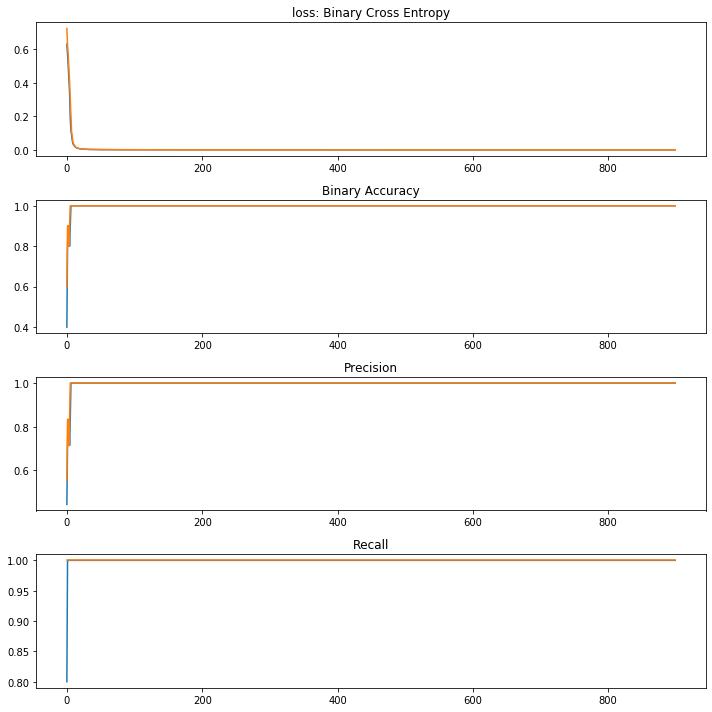

In [41]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), tight_layout=True)
ax[0].plot(history_cls.history['val_loss'])
ax[0].plot(history_cls.history['loss'])
ax[0].set_title('loss: Binary Cross Entropy')
ax[1].plot(history_cls.history['binary_accuracy'])
ax[1].plot(history_cls.history['val_binary_accuracy'])
ax[1].set_title('Binary Accuracy')
ax[2].plot(history_cls.history['precision'])
ax[2].plot(history_cls.history['val_precision'])
ax[2].set_title('Precision')
ax[3].plot(history_cls.history['recall'])
ax[3].plot(history_cls.history['val_recall'])
ax[3].set_title('Recall')
plt.show()

In [103]:
def decode_docs_feature_2(docs_feature, seed):
    np.random.seed(seed)
    docs_names = flatten_docs_feature(docs_feature)
    if len(docs_names) != 0:
        windows_doc_name = np.random.choice(docs_names, size=1)[0]
        with open(windows_doc_name, 'rb') as f:
            windows_doc = pickle.load(f)
        window = windows_doc
    else:
        window = []
    return np.asarray(window)

features, labels = extract_labels(dataset, ['log_adj_daily_returns'])
features_decoded = {key: (value if key != 'docs' 
                          else list(map(lambda docf: decode_docs_feature_2(docf, seed), value))) 
                    for key, value in features.items()}
# Checking the above steps
print(len(features_decoded['docs']))

mask = [(sample.shape[0] != 0) for sample in features_decoded['docs']]

features_filtered = {key: (value[mask, :] if key != 'docs'
                           else [value[i] for i in range(len(mask)) if mask[i]])
                     for key, value in features_decoded.items()}

labels_filtered = {key: value[mask] for key, value in labels.items()}
# Checking the above steps
assert all(sample.shape[0] != 0 for sample in features_filtered['docs'])

np.random.seed(seed)
shuffled_indices = np.random.choice(len(features_filtered['docs']), size=dataset_size, replace=False)

features_shuffled = {key: (value[shuffled_indices] if key != 'docs'
                           else [value[i] for i in shuffled_indices])
                     for key, value in features_filtered.items()}

labels_shuffled = {key: value[shuffled_indices] for key, value in labels_filtered.items()}

assert (features_shuffled['log_adj_daily_returns'].shape[0] == len(features_shuffled['docs']) == labels_shuffled['log_adj_daily_returns'].shape[0])
print(features_shuffled['log_adj_daily_returns'].shape[0])

def pad_documents_2(docs_feature):
    shapes = map(lambda arr: arr.shape, docs_feature)
    longest_doc_len = max(map(lambda shape: shape[-1], shapes))
    pad_doc = lambda arr:  np.pad(arr, ((0, longest_doc_len-arr.shape[-1])), constant_values=0)
    return np.stack(list(map(pad_doc, docs_feature)), axis=0)

X = {key: (pad_documents_2(value) if key == 'docs' else value) for key, value in features_shuffled.items()}
y = labels_shuffled['log_adj_daily_returns']
print(X['docs'].shape)

5024
1000
(1000, 2879)


In [104]:
# Creating a Model and attempting to overfit it
## Defining Model
tf.keras.backend.clear_session()

# Input Layers
input_log_returns = keras.Input(shape=(6,), name='log_adj_daily_returns', dtype=tf.float32)
input_doc = keras.Input(shape=(None,), name='docs', dtype=tf.int64)
# Building Word Embedding Layer
word_embedding_layer = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False, input_length=1466)(input_doc)
# Building Document Embedding Layer
document_embedding_layer = layers.LSTM(100)(word_embedding_layer)
# Creating input to time series layer
num_features = tf.expand_dims(input_log_returns, -1)
doc_features = tf.stack([document_embedding_layer for _ in range(6)], axis=1)
ts_input = layers.Concatenate()([doc_features, num_features])
# Time series component
ts_layer_1 = layers.LSTM(32, return_sequences=False)(ts_input)
#ts_layer_2 = layers.LSTM(500, return_sequences=True)(ts_layer_1)
#ts_layer_3 = layers.LSTM(300, return_sequences=True)(ts_layer_2)
#ts_layer_4 = layers.LSTM(160, return_sequences=True)(ts_layer_3)
#ts_layer_5 = layers.LSTM(50, return_sequences=False)(ts_layer_4)
output = layers.Dense(1)(ts_layer_1)

model = keras.Model([input_log_returns, input_doc], output, name='test_model')
model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=None)
print(model.summary())
keras.utils.plot_model(model, 'test.png', show_shapes=True)
print(batch_size)
history = model.fit(x=X, y=y, batch_size=batch_size, epochs=5, validation_data =(X, y))

Model: "test_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
docs (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    2747100     docs[0][0]                       
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100)          160400      embedding[0][0]                  
__________________________________________________________________________________________________
log_adj_daily_returns (InputLay [(None, 6)]          0                                            
_________________________________________________________________________________________

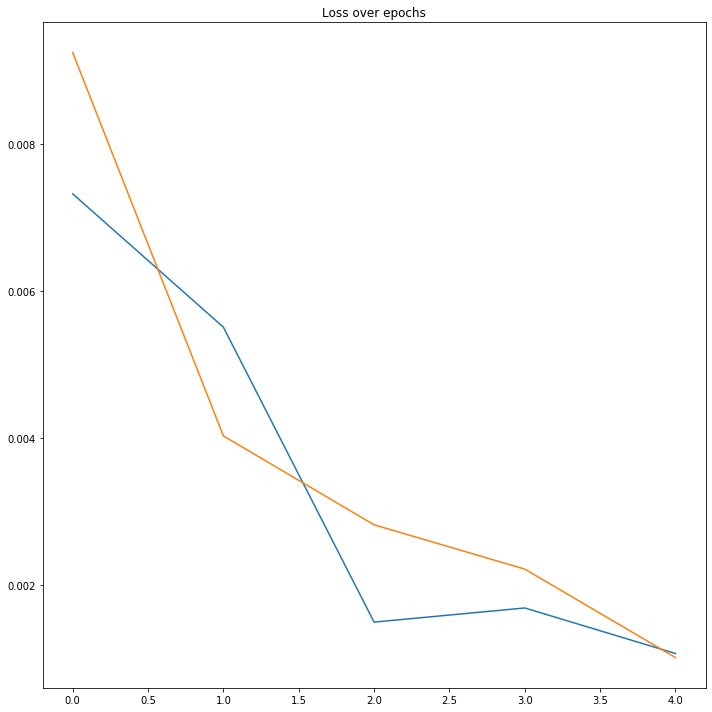

In [106]:
fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
ax.plot(history.history['val_loss'])
ax.plot(history.history['loss'])
ax.set_title('Loss over epochs')
plt.show()

## This is the tf dataset section

In [53]:
# Defining functions and classes used to load the dataset from its TFRecord file

def parse_example(example_proto, feature_description):
    '''
    Parses example proto from
    
    :param example_proto: 
    :param feature_description: 
    '''
    
    # Parse the input tf.Example proto using the dictionary above.
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Reconstructing Ragged Tensors from Example
    for t in tickers:
        example['_'.join(['docs', t])] = tf.RaggedTensor.from_row_lengths(example['docs_{}/vals'.format(t)].values,
                                                           row_lengths=example['docs_{}/lens'.format(t)].values)

    # Deleting Redundant Keys
    for t in tickers:
        del example['docs_{}/vals'.format(t)]
        del example['docs_{}/lens'.format(t)]
        
    return example

In [54]:
# Loading the Dataset

# Loading the raw dataset from the TFRecord file
dataset = tf.data.TFRecordDataset(os.path.join(path_to_data, 'dataset.tfrecord'))
# Loading the dataset's feature_description
with open(os.path.join(path_to_data, 'dataset_feature_description.pickle'), 'rb') as f:
    feature_description = pickle.load(f)
# Decoding the raw dataset using the dataset's feature_description
dataset = dataset.map(lambda example_proto: parse_example(example_proto, feature_description))

2. Spliting the dataset by stock ticker

In [55]:
def split(example, features, ticker):
    return {feature_name: example['_'.join([feature_name, ticker])] for feature_name in features}

datasets = [dataset.map(lambda ex: split(ex, ['log_adj_daily_returns', 'docs'], t)) for t in tickers]

3. Reshaping datasets

In [56]:
# Defining functions and classes used to reshape datasets

def make_window_dataset(ds, window_size, shift=1, stride=1):
    
    windows = ds.window(window_size, shift=shift, stride=stride)
    
    feature_datasets = {key: windows.flat_map(lambda x: x[key].batch(window_size, drop_remainder=True))
                        for key in windows.element_spec.keys()}
    
    return tf.data.Dataset.zip(feature_datasets)

def extract_labels(timeslice, label_features):
    labels = {}
    
    for feature_key in timeslice.keys():
        feature_timeslice = timeslice[feature_key]
        if feature_key in label_features:
            labels[feature_key] = feature_timeslice[-1]
        timeslice[feature_key] = feature_timeslice[:-1]
        
    return (timeslice, labels)


def to_time_series(ds, label_features, window_size, steps_to_pred=1, num_of_preds=1):
    
    # making full time series Dataset object (features + labels)
    full_ts_ds = make_window_dataset(ds, window_size=window_size+1)
    
    # mapping dataset to Dataset where each el is: (features: dict, labels)
    ts_ds = full_ts_ds.map(lambda s: extract_labels(s, label_features))
    
    return ts_ds

def sample_documents(sample):
    # Extracting all documents in the sample
    docs_in_sample = sample.values
    # Sampling a random document from all the documents in the sample
    if docs_in_sample.nrows() != 0:
        i = tf.random.uniform([1], maxval=docs_in_sample.nrows(), dtype=tf.int64)[0]
        sample_doc = docs_in_sample[i]
    else:
        sample_doc = tf.constant([], dtype=tf.int64)
        
    return sample_doc

def select_doc(features, labels):
    
    for fname in features.keys():
        feature = features[fname]
        timesteps = feature.shape[0]
        # Feature is a doc feature
        if isinstance(feature, tf.RaggedTensor):
            doc = sample_documents(feature)
            feature = tf.stack([doc for day in range(timesteps)])
            features[fname] = feature
        
    return (features, *list(labels.values()))

def filter_fn(f, l):
    shape = tf.shape(f['docs'])[1]
    return tf.math.not_equal(shape, 0)

def reshape(dataset, window_size, label_name):
    # Converting to time series
    ds = to_time_series(dataset, label_name, window_size=window_size)
    # Selecting document features
    ds = ds.map(select_doc)
    # Filtering out elements without a document feature
    ds = ds.filter(filter_fn)
    return ds

In [57]:
# Reshaping Datasets
reshaped_datasets = list(map(lambda d: reshape(d, TIMESTEPS, 'log_adj_daily_returns'), datasets))

4. Concatenating datasets, and shuffling dataset

In [58]:
dataset = reduce(lambda a, b: a.concatenate(b), reshaped_datasets).shuffle(1000, reshuffle_each_iteration=False)

5. Splitting dataset into train, validation, and test datasets

In [59]:
# Defining Functions and Classes for splitting datasets into train, validation, and test datasets

def k_folds(dataset, k):
    '''
    Splits :param dataset: into :param k: number of equally sized (or close to equally sized) components.
    
    :param dataset: tf.data.Dataset, dataset to split into k folds
    :param k: int, number of folds to split :param dataset: into
    
    ---> list, of tf.data.Dataset objets
    '''
    return [dataset.shard(k, i) for i in range(k)]

def train_test_split(dataset, train_size):
    '''
    Splits :param dataset: into
    
    :param dataset: tf.data.Dataset, to split into train and test datasets
    :param train_size: float between 0 and 1, proportion of :param dataset: to put into train dataset
    
    ---> (tf.data.Dataset, tf.data.Dataset), representing train, test datasets
    '''
    train_size = Fraction(train_size).limit_denominator()
    x, k = train_size.numerator, train_size.denominator
    folds = k_folds(dataset, k)
    train = reduce(lambda a, b: a.concatenate(b), folds[:x])
    test = reduce(lambda a, b: a.concatenate(b), folds[x:])
    return train, test

For our models we will reserve 60% of the dataset for training, 20% for validation, and 20% for testing.

In [60]:
# Splitting our dataset into train, validation, test datasets

# Creating datasets
train_dataset, test_val_dataset = train_test_split(dataset, train_size=0.6)
val_dataset, test_dataset = train_test_split(test_val_dataset, train_size=0.5)

# Prepping datasets for modeling
train_dataset = (train_dataset.shuffle(10)
                 .padded_batch(BATCH_SIZE, 
                               padded_shapes=({'log_adj_daily_returns': [TIMESTEPS,], 
                                               'docs': [TIMESTEPS, None]}, [])))
val_dataset = (val_dataset.shuffle(10)
               .padded_batch(BATCH_SIZE,
                             padded_shapes=({'log_adj_daily_returns': [TIMESTEPS,], 
                                             'docs': [TIMESTEPS, None]}, [])))
test_dataset = (test_dataset.shuffle(10)
                .padded_batch(BATCH_SIZE, 
                              padded_shapes=({'log_adj_daily_returns': [TIMESTEPS,], 
                                              'docs': [TIMESTEPS, None]}, [])))



### Evaluating Models

In [61]:
# Defining functions and classes used to construct model layers

def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                     weights=[current_embedding_matrix], mask_zero=mask_zero,
                                     input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = layers.Embedding(len(vocab) + 1, output_dim=init, 
                                     embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                     activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                     mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer


In [62]:
# Defining functions and classes used to construct models

def model_1(timesteps, vocab, doc_embedding_size, ts_layer_1_size, ts_layer_2_size, ts_layer_3_size,
            optimizer, learning_rate, loss, metrics):
    '''
    Constructs a model with the architecture of 
    '''
    
    # Building Input Layers
    input_docs = keras.Input(shape=(timesteps, None), name='docs', dtype=tf.int64)
    input_log_returns = keras.Input(shape=(timesteps,), name='log_adj_daily_returns', dtype=tf.float32)
    # Slicing Document Input Layer along time axis
    timeslice_layer = [input_docs[:, timestep, :] for timestep in range(timesteps)]
    # Building Word Embedding Layer
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)
    word_embedding_layer = [word_embedding(timeslice) for timeslice in timeslice_layer]
    # Building Document Embedding Layer
    document_embedding = layers.LSTM(doc_embedding_size)
    document_embedding_layer = [document_embedding(timeslice) for timeslice in word_embedding_layer]
    # Preparing Features for Time Series Analysis
    num_features = tf.expand_dims(input_log_returns, -1)
    doc_features = tf.stack(document_embedding_layer, axis=1)
    ts_input = num_features #layers.Concatenate()([doc_features, num_features])
    # Building Time Series Layer
    #ts_layer_1 = layers.LSTM(ts_layer_1_size, return_sequences=True)(ts_input)
    ts_layer_2 = layers.LSTM(ts_layer_2_size, return_sequences=True)(ts_input)
    ts_layer_3 = layers.LSTM(ts_layer_3_size)(ts_layer_2)
    # Building Output Layer
    output = layers.Dense(1, activation='sigmoid')(ts_layer_3)
    # Building Model
    model = keras.Model([input_docs, input_log_returns], output, name='model_1')
    # Compiling Model
    if learning_rate == None:
        opt = optimizer()
    else:
        opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model


In [64]:
# Training Model 1 with the current hyperparameters
tf.keras.backend.clear_session()
model = model_1(timesteps=TIMESTEPS, vocab=vocab, doc_embedding_size=DOC_EMBEDDING_UNITS,
                ts_layer_1_size=TS_LAYER_1_UNITS, ts_layer_2_size=TS_LAYER_2_UNITS, ts_layer_3_size=TS_LAYER_3_UNITS,
                optimizer=OPTIMIZER, learning_rate=LEARNING_RATE, loss=LOSS, metrics=METRICS)

print(model.summary())
# Converting data to catagorical data
def to_categorical(f, l):
    if l > 0:
        c = 1
    else:
        c = 0
    return (f, c)
#print(next(iter(train_dataset.unbatch().map(to_categorical).batch(BATCH_SIZE))))
t_dataset = train_dataset.unbatch().map(to_categorical).batch(BATCH_SIZE)
his = model.fit(t_dataset, epochs=900, validation_data=t_dataset)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
log_adj_daily_returns (InputLay [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 8, 1)]       0           log_adj_daily_returns[0][0]      
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 8, 1000)      4008000     tf_op_layer_ExpandDims[0][0]     
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 1000)         8004000     lstm_1[0][0]                     
____________________________________________________________________________________________

KeyboardInterrupt: 

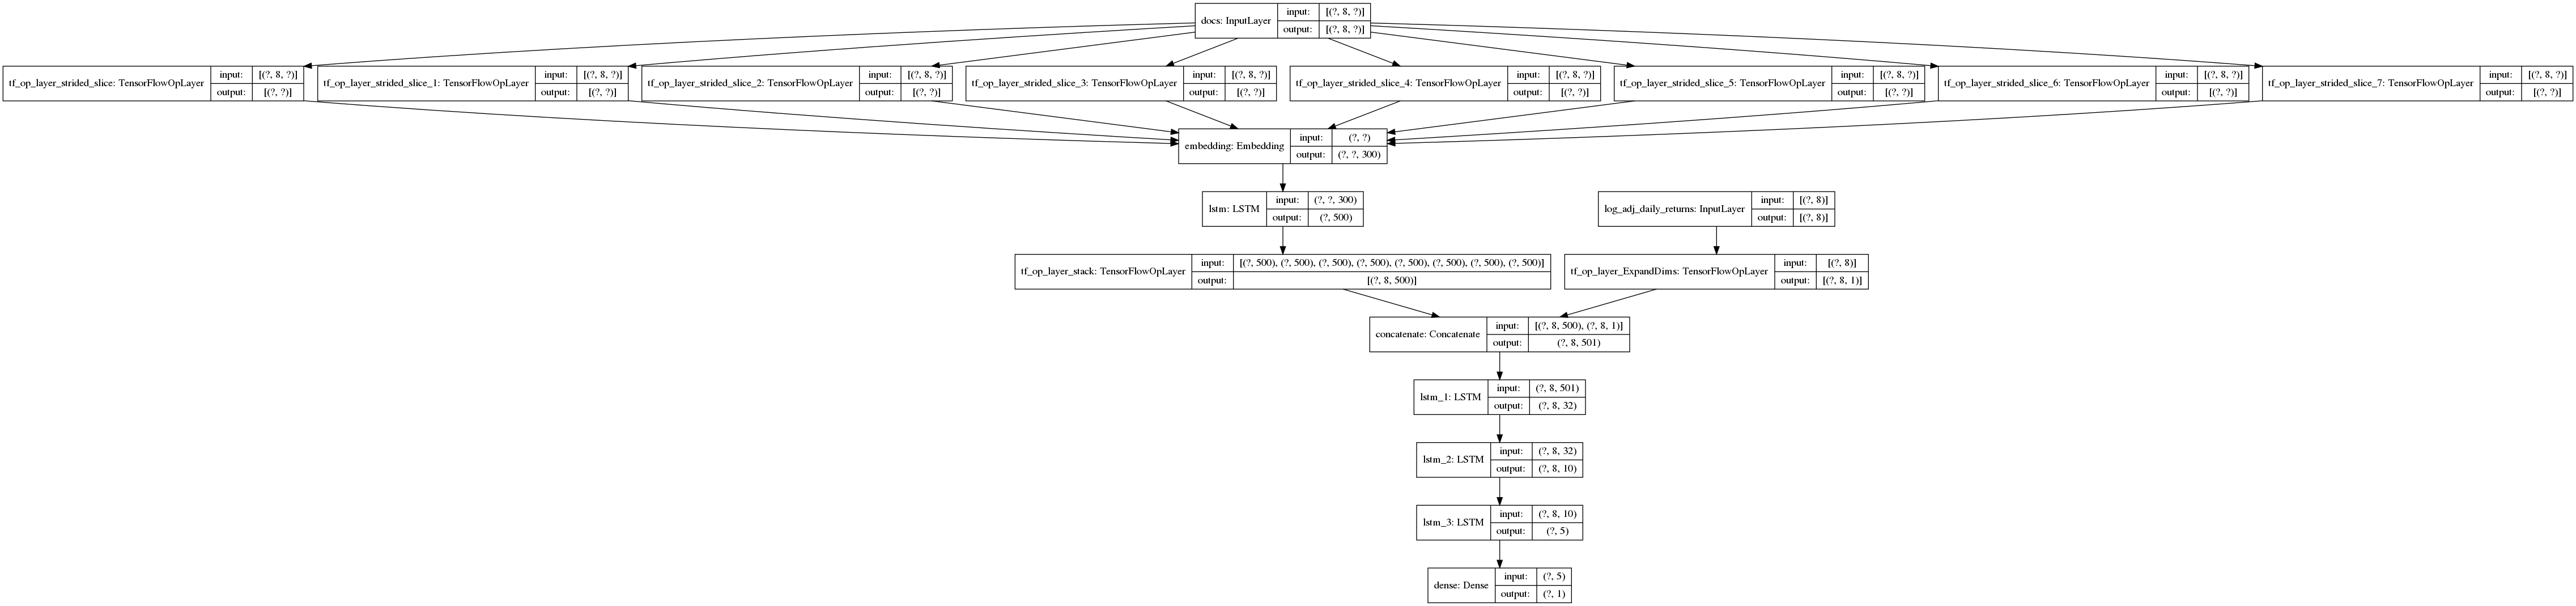

In [134]:
tf.keras.backend.clear_session()
optimizer = keras.optimizers.Adam()
loss = keras.losses.MeanSquaredError()
metrics = [keras.metrics.Accuracy()]
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)
hparams = {'timesteps': window_size, 'vocab': vocab, 'doc_embedding_size': 500, 'ts_layer_1_size': 32,
           'ts_layer_2_size': 10, 'ts_layer_3_size': 5}

model = get_compiled_model(optimizer=optimizer, loss=loss, metrics=metrics, model=model_1, **hparams)
keras.utils.plot_model(model, 'test.png', show_shapes=True)

In [111]:


feature_names = ['log_adj_daily_returns', 'docs_WFC', 'docs_JPM', 'docs_C', 'docs_BAC']

# destroying already made graph nodes in the tensorflow backend





timesteps = 5




# document embedding Model

    
with open(os.path.join(path_to_data, 'vocab.json')) as f:
    vocab = json.load(f)
        
#document = keras.Input(shape=(None,), name='document')
#word_embedding = Word_Embedding(vocab, trainable=False)(document)
#document_embedding = layers.LSTM(400)(word_embedding)
#document_embedder = keras.Model(document, document_embedding, name='document_embedder')
#print(document_embedder.summary())

#keras.utils.plot_model(document_embedder, 'document_embedder.png', show_shapes=True)



# Inputs
input_docs_WFC = keras.Input(shape=(timesteps, None), name='docs_WFC')
#input_docs_JPM = keras.Input(shape=(timesteps, None), name='docs_JPM')
#input_docs_BAC = keras.Input(shape=(timesteps, None), name='docs_BAC')
#input_docs_C = keras.Input(shape=(timesteps, None), name='docs_C')
input_log_returns = keras.Input(shape=(timesteps,), name='log_adj_daily_returns')

# Splitting docs_WFC input into its individual timesteps
timesteps_layer = [input_docs_WFC[:, t] for t in range(timesteps)]

# Flattening Documents Dimension for each timestep (cause I don't know how to deal with the extra dimension for the LSTM)
#flattened_timesteps_layer = [tf.reshape(timestep, [-1, tf.reduce_prod(tf.shape(timestep)[1:])]) for timestep in timesteps_layer]

# Word Embedding Layer
word_embedding = Word_Embedding(vocab, init='glove', trainable=True, mask_zero=True)
word_embedding_layer = [word_embedding(timestep) for timestep in timesteps_layer]


# Document Embedding Layer
document_embedding = layers.LSTM(100)
doc_embedding_layer = [document_embedding(timestep) for timestep in word_embedding_layer]

# Preparing Inputs for Time Series
num_features = tf.expand_dims(input_log_returns, -1)
doc_features = tf.stack(doc_embedding_layer, axis=1)
ts_input = layers.Concatenate()([doc_features, num_features])



# Time Series Component
time_series = layers.LSTM(100)(ts_input)

# Output
output = layers.Dense(1)(time_series)

# Creating Model
test_model = keras.Model({'docs_WFC': input_docs_WFC, 'log_adj_daily_returns': input_log_returns}, output, name='test_model')

# Compiling Model
test_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())





# Training Model
#test_ds = tsds.batch(1).repeat()


#test_model.fit_generator(test_ds, epochs=3, steps_per_epoch=100)
keras.utils.plot_model(test_model, 'test.png', show_shapes=True)

IndexError: list assignment index out of range

In [7]:
d = tf.data.Dataset.range(10)
d.element_spec.dtype


tf.int64

### Text Embedding

In [4]:


def preprocess_pm(raw_df):
    '''
    Preprocessing raw_df into the shape raw_df should have been after coming out of the fetch process, as well as 
    normalizing the documents.
    '''
    
    # Reshaping DataFrame
    reshaped_df = reshape(raw_df)
    
    # Normalizing and updating documents    
    def update_doclist(s):
        doclist = json.loads(s)
        updated_doclist = []
        for docpath in doclist:
            save_point = os.path.join(os.path.split(docpath)[0], 'normalized')
            norm_docpath = normalize_save_document(docpath, save_point)
            updated_doclist.append(norm_docpath)
            
        return json.dumps(updated_doclist)
    
    for t in tickers:
        reshaped_df['_'.join(['docs', t])] = reshaped_df['_'.join(['docs', t])].map(update_doclist)
        
    # Preprocessing numerical data
    reshaped_df['log_adj_close'] = np.log(reshaped_df['adjusted_close'])
    reshaped_df['log_adj_daily_returns'] = reshaped_df['log_adj_close'] - reshaped_df['log_adj_close'].shift(-1)
    reshaped_df.dropna(subset=['log_adj_daily_returns'], inplace=True)
    
    # Building vocabulary json file
    path_to_vocab = os.path.join(path_to_data, 'vocab.json')
    
    def vocab_from_doclist(s):
        
        doclist = json.loads(s)
        
        for docpath in doclist:
            with open(docpath, 'r') as f:
                doc = f.read()
            
            build_vocab(doc)
        
        return json.dumps(doclist)
    
    for t in tickers:
        reshaped_df['_'.join(['docs', t])].map(vocab_from_doclist)
        
    # Encoding documents based off of vocabulary json file
    
    
    return reshaped_df

In [5]:
# Writing tfrecords

feature_names = ['log_adj_daily_returns', 'docs_WFC', 'docs_JPM', 'docs_C', 'docs_BAC']
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)


# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
    '''Returns a bytes_list from a string / byte.'''
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    '''Returns a float_list from a float / double.'''
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    '''Returns an int64_list from a bool / enum / int / uint.'''
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(sample, feature_names):
    
    feature = {}
    
    for feature_name in feature_names:
        # if feature is a number 
        if isinstance(sample[feature_name], float):
            feature[feature_name] = tf.train.Feature(float_list=tf.train.FloatList(value=[sample[feature_name]]))
        
        # if feature is a doclist
        elif isinstance(sample[feature_name], list):
            lens = list(map(len, sample[feature_name]))
            values = [word for doc in sample[feature_name] for word in doc]
            feature[feature_name + '/vals'] = tf.train.Feature(int64_list=tf.train.Int64List(value=values))
            feature[feature_name + '/lens'] = tf.train.Feature(int64_list=tf.train.Int64List(value=lens))

    return tf.train.Example(features=tf.train.Features(feature=feature))
        


def unpack_doclist(doclist_string):        
    def load_encode_file(filename):
        with open(filename, 'r') as f:
            text = f.read()
        return [vocab[word] for word in text.split()]
    return list(map(load_encode_file, json.loads(doclist_string)))


record_file = 'test.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    for i in range(300, -1, -1):
        row = raw_df_fixed.iloc[i].copy(deep=True)
        # Unpacking Text Features
        row[['_'.join(['docs', t]) for t in tickers]] = row[['_'.join(['docs', t]) for t in tickers]].map(unpack_doclist)
        # Serializing Example to disk
        example = serialize_example(row, feature_names)
        writer.write(example.SerializeToString())
    


Preparing our data involves:
1. Loading the dataset from the TFRecord file
2. Splitting the dataset by stock ticker
3. Reshaping each dataset to prepare it for training:
    1. Windowing the dataset so each element produces a time series of features along with there corresponding label
    2. Sampling the document feature for the document that will represent the specific window's document and cloning that document for each timestep in our defined window size
    3. Filtering our dataset to include only elements with a document feature
4. Concatenating the reshaped datasets together, and shuffling the dataset
5. Splitting the dataset into train, validation, and test datasets

1. Loading the dataset from TFRecord file

### Writing Dataset to TFRecords

After sucessfully preprocessing our dataset we next write our dataset to a TFRecords file (https://www.tensorflow.org/tutorials/load_data/tfrecord) a binary file format that is read efficiently by the TensorFlow framework. 

In [3]:
# Defining Functions and Classes used to write TFRecord files

def serialize_example(sample, feature_names):
    '''
    Maps dictionary :param sample: to a tf.train.Example object where the list feature_names determines which 
    subset of :param sample:'s keys are to be used. 
    
    :param sample: dict, where the keys are the names of the features of the specific data sample, and the values 
                   are the values each feature takes on for the specific data sample
    :param feature_names: list, of strings, a subset of sample.keys(), these are the features we will
                          be considering for analysis
    
    ---> tf.train.Example, object representing the data sample
    '''
    
    feature = {}
    feature_description = {}
    
    for feature_name in feature_names:
        # if feature is a float number 
        if isinstance(sample[feature_name], float):
            feature[feature_name] = tf.train.Feature(float_list=tf.train.FloatList(value=[sample[feature_name]]))
            feature_description[feature_name] = tf.io.FixedLenFeature([], tf.float32)
        
        # if feature is a list of documents
        elif isinstance(sample[feature_name], list) and all(isinstance(word, int) for doc in sample[feature_name] for word in doc):
            lens = list(map(len, sample[feature_name]))
            values = [word for doc in sample[feature_name] for word in doc]
            feature[feature_name + '/vals'] = tf.train.Feature(int64_list=tf.train.Int64List(value=values))
            feature[feature_name + '/lens'] = tf.train.Feature(int64_list=tf.train.Int64List(value=lens))
            feature_description[feature_name + '/vals'] = tf.io.VarLenFeature(dtype=tf.int64)
            feature_description[feature_name + '/lens'] = tf.io.VarLenFeature(dtype=tf.int64)
        
        # if feature is an integer number
        elif isinstance(sample[feature_name], int):
            feature[feature_name] = tf.train.Feature(int64_list=tf.train.Int64List(value=[sample[feature_name]]))
            feature_description[feature_name] = tf.io.FixedLenFeature([], tf.int64)
        
        # Feature doesn't fit any of the tf example types
        else:
            raise ValueError('Value of Feature does not fit any of the tf.train.Feature serializable types')

    return tf.train.Example(features=tf.train.Features(feature=feature)), feature_description


def write_tfrecord(df, feature_names, filename='dataset.tfrecord'):
    '''
    Writes TFRecord file named :param filename: to dataset directory, and generates the corresponding 
    feature_description dictionary mapping a sample's feature name to the data type description of that
    feature.
    
    :param df: pd.DataFrame, containing data and refrences to data that needs to be written to disk
    :param feature_names, list of strings, a subset of the names of columns of df, that represents which subset
                          of features from our preprocessed DataFrame that will be considered for modeling
    :param filename: string, name of TFRecord file
    
    ---> dict, of names of features mapping to tf.io.VarLenFeature and tf.io.FixedLenFeature objects
    '''
    
    def unpack_doclist(doclist_string):
        '''
        Takes a json format string that when loaded contains a list of paths to encoded document pickle files, and
        returns a list of the objects loaded from these pickle files.
        
        :param doclist_string: string, json formated, contain a list of paths to encoded document pickle files
        
        ---> list, of encoded documents
        '''
        
        def load_file(filename):
            '''
            Takes a path to a pickle file, and returns the loaded object.
            
            :param filename: string, path to pickle file
            
            ---> python object loaded file located at :param filename:
            '''
            
            with open(filename, 'rb') as f:
                doc = pickle.load(f)
            return doc
        
        return list(map(load_file, json.loads(doclist_string)))
    
    with tf.io.TFRecordWriter(os.path.join(path_to_data, filename)) as writer:
        print('Writing TFRecord file to: {}'.format(os.path.join(path_to_data, filename)))
        for i in range(len(df)-1, -1, -1):
            row = df.iloc[i].copy(deep=True)
            # Unpacking Text Features
            row[['_'.join(['docs', t]) for t in tickers]] = row[['_'.join(['docs', t]) for t in tickers]].map(unpack_doclist)
            # Serializing Example to disk
            example, feature_description = serialize_example(row, feature_names)
            writer.write(example.SerializeToString())
    print('Finished writing TFRecord file.')

    return feature_description

In [4]:
# Writing TFRecord file

# Defining the subset of features from our preprocessed DataFrame that we will be using for modeling
feature_names = ['_'.join([feature, t]) for feature in ['log_adj_daily_returns', 'docs'] for t in tickers]
print('The features we will be considering for analysis are: {}'.format(', '.join(feature_names)))
print()
# Loading the preprocessed DataFrame from disk if it has not been instantiated
try:
    preprocessed_df
except:
    preprocessed_df = pd.read_csv(os.path.join(path_to_data, 'preprocessed.csv'), parse_dates=['timestamp'])
# Writing the TFRecord file
feature_description = write_tfrecord(preprocessed_df, feature_names)
# Writing the TFRecord's feature_description object to disk
with open(os.path.join(path_to_data, 'dataset_feature_description.pickle'), 'wb') as f:
    pickle.dump(feature_description, f)

The features we will be considering for analysis are: log_adj_daily_returns_WFC, log_adj_daily_returns_JPM, log_adj_daily_returns_BAC, log_adj_daily_returns_C, docs_WFC, docs_JPM, docs_BAC, docs_C

Writing TFRecord file to: /media/Data/Programs/FinTech/data/dataset.tfrecord
Finished writing TFRecord file.


For this notebook we will be using only the bare minimum amount of features for modeling ie: our text features listed in the doc columns and the feature we are trying to predict in time series.

In [4]:
X, y = sample_dataset(train_dataset, sample_size=1.0, seed=seed)
#X_train, y_train = train_dataset
X_null = null_features(X)
#X_train_null = null_features(X_train)
#manually splitting
X_small = {fname: X[fname][0:16, :] for fname in X}
y_small = {fnamey: y[fnamey][0:16] for fnamey in y}
X_small_null = null_features(X_small)

epochs = 10
batch_size = 8
output_bias_init = 0.0
hparams = {'output_bias_init': output_bias_init}

m = build_compiled_model(model_0, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X_small_null, y_small, batch_size=batch_size, epochs=epochs)
#m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

print()
print('Metrics for model trained on zeroed features.')
print()
#print('Loss for Model: {}'.format(m_results))
print()
tf.keras.backend.clear_session()

Train on 16 samples
Epoch 1/10
16/16 [==============================] - 2458s 154s/sample - loss: 0.2878
Epoch 2/10
16/16 [==============================] - 2158s 135s/sample - loss: 0.0603
Epoch 3/10
16/16 [==============================] - 1987s 124s/sample - loss: 0.1277
Epoch 4/10
16/16 [==============================] - 2019s 126s/sample - loss: 0.0161
Epoch 5/10
16/16 [==============================] - 2026s 127s/sample - loss: 0.0145
Epoch 6/10
16/16 [==============================] - 2171s 136s/sample - loss: 0.0319
Epoch 7/10
16/16 [==============================] - 2116s 132s/sample - loss: 0.0158
Epoch 8/10
16/16 [==============================] - 2150s 134s/sample - loss: 0.0013
Epoch 9/10
16/16 [==============================] - 2187s 137s/sample - loss: 0.0047
Epoch 10/10
16/16 [==============================] - 2142s 134s/sample - loss: 0.0105

Metrics for model trained on zeroed features.




In [5]:
m_results = m.evaluate(X_small, y_small, batch_size=batch_size, verbose=0)

In [8]:
print('Metrics for model trained on zeroed features.')
print()
print('Loss for Model: {}'.format(m_results))

Metrics for model trained on zeroed features.

Loss for Model: 0.012423759326338768


In [7]:
m.save('m0_default_E10_B8_train_on_null16')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: m0_default_E10_B8_train_on_null16/assets


In [12]:
test_m = tf.keras.models.load_model('m0_default_E10_B8_train_on_null16')
print(test_m.evaluate([X_small['docs'], X_small['log_adj_daily_returns']], y_small['log_adj_daily_returns_target'], batch_size=batch_size, verbose=0))

0.012423759326338768
